Kaige Yang (github)  
https://github.com/yang0110/GraphUCB-and-GraphUCB-Local-Algorithms

# 1) Import

In [3]:
import numpy as np 
import networkx as nx
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.preprocessing import Normalizer, MinMaxScaler
from scipy.sparse import csgraph 
import scipy
import os
import random
from sklearn import datasets
import matplotlib.pyplot as plt
from google.colab import files
import time

# 2) Graph

In [4]:
def create_networkx_graph(node_num, adj_matrix):
	G=nx.Graph()
	G.add_nodes_from(list(range(node_num))) #0,1,...,node_num이 G의 node가 된다.
	for i in range(node_num):
		for j in range(node_num):
			if adj_matrix[i,j]!=0.0:
				G.add_edge(i,j,weight=adj_matrix[i,j])
                #edge를 matrix가 아닌 node1, node2, weight 로 저장
			else:
				pass
	return G, G.number_of_edges()

In [5]:
# 뒤에 run 하는 코드에서 결국 이거를 안쓰는듯..? 그냥 import한 rbf_kerner을 쓰는듯?
def RBF_graph(node_num, dimension, rho=None, thres=None, clusters=False): 
	if clusters==False:
		node_f=np.random.uniform(low=-0.5, high=0.5, size=(node_num, dimension))
        #각 node의 theta(d-dim임)를 할당하는 과정
	else:
		node_f, _=datasets.make_blobs(n_samples=node_num, n_features=dimension, centers=5, cluster_std=0.1, center_box=(-1,1),  shuffle=False, random_state=2019)
        #Generate isotropic Gaussian blobs for clustering
        #그런데 굳이 cluster를 주고 하는 이유는? 유사성이 있는 node들이(center가 같은 node) 생기도록 하기 위함인가?
	if rho==None:
		rho=0.5
	else:
		pass 
	adj=rbf_kernel(node_f, gamma=rho) # Compute the rbf (gaussian) kernel 
	# from sklearn.metrics.pairwise import rbf_kernel로 가져왔음

	adj=np.round(adj, decimals=2) #계산의 편의를 위함인가?

	if thres!=None: #뒤에 나오는 sparsity 조절하는 parmeter s를 treshold라 명명
		adj[adj<=thres]=0.0
	else:
		pass
	np.fill_diagonal(adj,1) #이거는 굳이 안필요할듯? 이미 위를 통해 1로 나오는데? 0으로 채우는 것도 아니고
	return adj 

In [6]:
def ER_graph(node_num, prob): ## 0,1뿐
	G=nx.erdos_renyi_graph(node_num, prob) # Returns a random graph, also known as an Erdős-Rényi graph
	adj=nx.to_numpy_matrix(G) #node1, node2, weight로 저장되어있는 edge를 matrix로 바꿔줌
	adj=np.asarray(adj) #array로 변환
	#adj=adj+np.identity(node_num)
	return adj 

In [7]:
def graph_signal_samples_from_laplacian(laplacian, node_num, dimension):
	cov=np.linalg.pinv(laplacian) #pinv를 써서 계산량을 줄인듯?
	samples=np.random.multivariate_normal(np.zeros(node_num),cov, size=dimension).T
    #N결국 ormal(0-vec, laplacian_inv)에서 d-dim sample을 뽑아서, column vec 형태로 sample을 output
	return samples 

In [8]:
def dictionary_matrix_generator(node_num, dimension, laplacian, lambda_):
    # equation(19)의 solution을 explicit하게 계산 : smooth Theta
    # reference : [Yankelevsky and Elad, 2016]의 식(25)

	# np.random.seed(2018)
	D0=np.random.normal(size=(node_num, dimension)) # 아무 Theta0 선택
	D=np.dot(np.linalg.pinv(np.identity(node_num)+lambda_*laplacian), D0) # equation (19)의 sol
	D=Normalizer().fit_transform(D) #row vector의 l2 norm이 1이 되도록 함
	return D

In [9]:
def normalized_trace(matrix, target_trace):
    # matrix를 scalar배 : 단, target_trace가 output matrix의 trace가 되도록.
	normed_matrix=target_trace*matrix/np.trace(matrix)
	return normed_matrix

# 3) Graph UCB

In [10]:
class LAPUCB(): 
    # dimension : d // iteration : time horizion T // user_num : number of total users //
    # item_num :  전체 가능한 item의 수 (LAPUCB class 안에서 딱히 사용되지 않기는 한다.)
    # pool_size : 매 step마다 가능한 item의 수
    # item_num과 pool_size의 차이 : Kaige Yang github의 run_artifical.py의 line 41보면 item_num 개 중에서 pool_size 개 만큼을 선택함을 알 수 있음
    # item_feature_matrix : arms' features(x) // true_user_feature_matrix : true Theta
    # true_payoffs : x * Theta // # true_adj : adjacency map(W) # true_lap : (random walk) Laplacian
    # alpha, delta, sigma : parameter(alpha - eq(4), delta -  eq(11), sigma - eq(2))
    # beta : parameter for CLUB, SCLUB and GOB 
    # thres : threshold for sparsity(figure3) // state : true or false(artificial or real data)
    
    def __init__(self, dimension, iteration, user_num, item_num, pool_size, item_feature_matrix, true_user_feature_matrix, true_payoffs, true_adj, true_lap, alpha, delta, sigma, beta, thres, state):
        self.true_adj=true_adj
        self.state=state
        self.dimension=dimension
        self.iteration=iteration
        self.user_num=user_num
        self.item_num=item_num
        self.pool_size=pool_size
        self.item_feature_matrix=item_feature_matrix
        self.true_user_feature_matrix=true_user_feature_matrix
        self.true_payoffs=true_payoffs
        self.thres=thres
        self.adj=true_adj
        self.lap=true_lap
        self.alpha=alpha
        self.delta=delta
        self.sigma=sigma
        self.beta=beta
        
        self.user_v={} # V in eq(11)
        self.user_avg={} # Delta in eq(11) : Laplacian으로 weighted average 된 Theta라는 의미인 듯
        self.user_xx={} # A_(i,t) in eq(7); or, for "Phi dot Phi_transpose" in eq(5) / 대신 user 별로 저장 (block diagonal 이니까)
        self.user_bias={} # Phi dot Y in eq(5). 
        self.user_counter={} # how many times the user has been selected 
        self.user_h={} # Lambda for each user (Lambda_i 들의 모음에 해당)
        
        self.user_feature_matrix=np.zeros((self.user_num, self.dimension)) # Theta hat
        
        self.L=self.lap.copy()+0.01*np.identity(self.user_num) #laplacian : "+0.01*identity" for inverse 인듯
        self.kron_L_id=np.kron(self.L, np.identity(self.dimension)) # kron(laplacian, identity) in eq(5) and eq(9)
        self.kron_L_id_inv=np.linalg.pinv(self.kron_L_id) # inverse of self.kron_L_id
        
        self.XX=np.zeros((self.user_num*self.dimension, self.user_num*self.dimension))
        # nd x nd matrix : A in eq (9) = "Phi dot Phi_transpose" = eq(5)에서도 등장
        
        self.cov=self.alpha*self.kron_L_id  # alpha * kron(Laplacian, identity) : it will be used for eq(5)
        self.cov_inv=np.linalg.pinv(self.cov) # inverse of self.cov
        
        self.user_ls=np.zeros((self.user_num, self.dimension)) # n x d matrix
        self.user_ridge=np.zeros((self.user_num, self.dimension))  # n x d matrix
        
        self.bias=np.zeros((self.user_num*self.dimension)) # eq(5)의 Phi dot Y를 저장하는 용도.
        self.beta_list=[] # beta를 update해 시간에 따라 저장
        self.real_beta_list=[] # real_beta_list는 굳이 필요 없어보임.
        
        self.graph_error=[]
        
        
    def initialized_parameter(self):
        for u in range(self.user_num):
            self.user_v[u]=self.alpha*np.identity(self.dimension) # V in eq (11)
            self.user_avg[u]=np.zeros(self.dimension)
            self.user_xx[u]=0.1*np.identity(self.dimension) # A_(i,t) in eq7 : 이러한 initialization 하는 이유 = eq(8) 아래의 주석1 참고
            self.user_bias[u]=np.zeros(self.dimension)
            self.user_counter[u]=0 # how many times the user has been selected 
            self.user_h[u]=np.zeros((self.dimension, self.dimension)) # Lambda for each user
            
    def update_beta(self, user_index):
        # step 1 : update Lambda via eq(10)
        # 특징은, 선택된 user의 Lambda만 update한다는 것! user_h[user_index]만 update하는 것을 보면 알 수 있음
        #QQQQ : 사실 eq(10)은 모든 user에 대해 update 하는게 맞는데...
        sum_A=np.zeros((self.dimension, self.dimension))
        for uu in range(self.user_num):
            if uu==user_index:
                #pass
                #QQQQ : 원래코드에서는 pass를 사용했는데, 왜 pass를 했는지 모르겠음. eq(10)에 따르면 모든 j에 대해서 A_(j,t)의 inverse를 더해야하는데?
                sum_A+=((self.L[user_index, uu])**2)*np.linalg.inv(self.user_xx[uu]) #이게 정확히 eq(10)에서 alpha^2에 붙어있는 summation에 해당
            else:
                sum_A+=((self.L[user_index, uu])**2)*np.linalg.inv(self.user_xx[uu]) #이게 정확히 eq(10)에서 alpha^2에 붙어있는 summation에 해당
        self.user_h[user_index]=self.user_xx[user_index]+self.alpha**2*sum_A+2*self.alpha*self.L[user_index, user_index]*np.identity(self.dimension)
        # 위에 식은 eq(10) 최종 계산 : A_{i,t} + alphta^2 * SIGMA_PART + 2 * alpha * L_{i,i}^w * id

        # step 2-1 : eq(11)의 앞부분
        a=np.linalg.det(self.user_v[user_index])**(1/2) # |V_{i,t}|^{1/2} : V는 ubdate_beta 함수를 들어오기 전에 이미 update가 되어있어야 하긴 함.
        b=np.linalg.det(self.alpha*np.identity(self.dimension))**(-1/2) # |alpha * identity|^{-1/2}
        d=self.sigma*np.sqrt(2*np.log(a*b/self.delta)) # sqrt안에 term 계산
        
        # step 2-2 : eq(11)의 뒷부분. 즉, Delta_i 계산.

        # QQQQ : 여기서도 self.user_counter[user_index]==0이라는 건 처음으로 특정 user가 선택된 경우인데,
        # 왜 굳이 그런 경우와 아닌 경우로 나누었는지 모르겠음. 심지어 같은 연산을 수행하는 코드로 되어있음.

        # QQQQ : 또한가지 드는 의문은 true_user_feature_matrix.T를 이용해서 Delta를 계산해도 되는가? 임.
        # 이걸 알고있는게 말이 안되지 않나?? 그냥 user_feature_matrix를 써야하는거 아닌가????
        # 물론, state에 따라서 user_ls를 쓰기도 한다. 참고로, artificial dataset를 쓴 경우는 state=0임. (이는 Kaige Yang github의 run_artifical.py의 line 38을 보면 알 수 있음)
        # 그렇다 하더라도 true feature matrix를 쓰는게 좀....
        # 일단 아래 run에서는 state를 1로 맞춰놓음(원래코드에서도)
        
        if self.user_counter[user_index]==0:
            if self.state==1:
                self.user_avg[user_index]=np.dot(self.user_ls.T, self.L[user_index])
            else:
                self.user_avg[user_index]=np.dot(self.true_user_feature_matrix.T, self.L[user_index])
        else:
            if self.state==1:
                self.user_avg[user_index]=np.dot(self.user_ls.T, self.L[user_index])
            else:
                self.user_avg[user_index]=np.dot(self.true_user_feature_matrix.T, self.L[user_index])
        
        #step 2-3 : eq(11) 계산 완료 통한 beta의 update
        c=np.sqrt(self.alpha)*np.linalg.norm(self.user_avg[user_index])
        self.beta=c+d
        self.beta_list.extend([self.beta]) # 그리고 beta를 beta_list라는 list에 시간에 따라 계속 추가하여 저장
        
        #######
        # 이 real beta라는 건 필요가 없어 보임. 이후 algorithm별로 실행을 하고 plot을 그리는 중에도 필요 없음.
        diff=self.user_feature_matrix[user_index]-self.true_user_feature_matrix[user_index]
        real_beta=np.sqrt(np.dot(np.dot(diff, self.user_h[user_index]), diff))
        self.real_beta_list.extend([real_beta])
        #######
        
    def select_item(self, item_pool, user_index, time):  # eq(12)를 통한 arm selection : 논문의 Algorithm 1 의 3 ~ 5단계에 해당

        # 현재 선택 가능한 arm들(그 수는 pool_size만큼이며, 이미 item_pool에 가능한 arm들이 지정되어 있음.)
        item_fs=self.item_feature_matrix[item_pool] # 현재 선택 가능한 arm들의 feature만 모아서 다시 저장.
        estimated_payoffs=np.zeros(self.pool_size)
        self.update_beta(user_index) # 즉, 앞서 만들어놓은 beta를 update하는 과정이 포함되어 있음
        h_inv=np.linalg.pinv(self.user_h[user_index]) # Lambda[user]의 inverse : (Lambda_{i,t})^{-1}
        
        # step 1 : 현재 가능한 모든 arm에 대해 eq(12) 값을 계산해서 저장
        for j in range(self.pool_size):
            
            x=item_fs[j] # 현재 가능한 arm들의 리스트 중에서 j번째를 선택
            x_norm=np.sqrt(np.dot(np.dot(x, h_inv),x)) # Mahalanobis distance 계산
            mean=np.dot(x, self.user_feature_matrix[user_index]) # eq(12)의 앞부분
            est_y=mean+self.beta*x_norm # eq(12)의 뒷부분까지 계산해서 더함
            estimated_payoffs[j]=est_y # eq(12) 계산값을 list에 저장
            ucb=self.beta*x_norm # 이 ucb라는 변수는 쓸모가 없음.
            
        # step 2 : arm들 간의 eq(12) 값을 비교해서 argmax 선택
        max_index=np.argmax(estimated_payoffs) # 그런데 사실 이 max_index는 현재 가능한 arm들의 list 중에서 몇번째냐를 알려준 것이다.
        selected_item_index=item_pool[max_index] # 따라서 전체 arm들 중에 무슨 arm인지는, 현재 가능한 arm들의 list에 접근해서 알아야 함.
        selected_item_feature=item_fs[max_index] # item_fs는 현재 가능한 arm들의 feature만을 모은 것이므로, 그대로 max_index를 사용해도 문제 없음.
        
        true_payoff=self.true_payoffs[user_index, selected_item_index]+np.random.normal(scale=self.sigma) # true_payoff는 실제 run 시, 아주 처음부터 계산해놓고 저장해두게 된다.
        # x dot theta + noise : 원래는 subgaussian noise지만 일단은 gaussian으로 했음
        max_ideal_payoff=np.max(self.true_payoffs[user_index][item_pool]) # 현재 가능한 arm들 중, 가능한 최대의 true mean payoff 찾기.
        regret=max_ideal_payoff-true_payoff #QQQQ : 이것도 살짝 이상한 것 같은데. true_optimal_mean에서 perturbation 포함된 실제로 받은 payoff를 뺐는데? 불공정한 비교 아닌가?
        
        return true_payoff, selected_item_feature, regret, x_norm, ucb
        
    def update_user_feature(self, true_payoff, selected_item_feature, user_index):
        # 논문의 Algorithm 1의 6단계 해당 : use eq(4) and (5)
        # 그런데 다음 algorithm step의 1, 2도 미리 해놓는다.

        x=selected_item_feature # 이는 바로 위에서 정의한 select_item함수의 두 번째 return값이 들어가게 된다 : 알고리즘으로 선택한 arm의 feature vector이다.
        x_long=np.zeros((self.user_num*self.dimension)) # eq(5) 아래에서 정의된 pi_t 에 해당하는데, 다음 line으로 저장.
        x_long[user_index*self.dimension:(user_index+1)*self.dimension]=x 
        
        self.user_v[user_index]+=np.outer(x, x) # update V_(user,t)
        self.user_xx[user_index]+=np.outer(x, x) # update A_(user,t) : 이부분이 Algorithm 1의 1, 2단계에 해당.
        # 이와 더불어 A의 다른 형태인 Phi dot Phi_transpose(=self.XX) / self.user_bias / self.cov 등도 여기서 미리 update한다!
        
        self.user_bias[user_index]+=true_payoff*x # Phi dot Y의 업데이트: 원래는 nd-vec인데, 저장을 n개의 d-vector로 해서, 선택한 user에 대한 부분만 update
        self.user_ls[user_index]=np.dot(np.linalg.pinv(self.user_xx[user_index]), self.user_bias[user_index]) # eq(7) 뒷부분 계산 일부 : GraphUCB-local에서 사용
        
        self.cov+=np.outer(x_long, x_long) # for eq5 : Phi dot Phi_transpose + alpha * kron. 이미 self.cov는 초기에는 alpha * kron으로 설정되어있는 상태.
        self.XX+=np.outer(x_long, x_long) # update Phi dot Phi_transpose
        self.bias+=true_payoff*x_long # update Phi dot Y : as nd x 1 vector
        self.cov_inv=np.linalg.pinv(self.cov)
        
        self.user_feature_matrix=np.dot(self.cov_inv, self.bias).reshape((self.user_num, self.dimension)) # eq(5) 계산해서 다시 matrix 형태로 바꾸기

        for u in range(self.user_num): #QQQQ : 그냥 이 for문 자체가 의미 없어보이는데?
            v_inv=np.linalg.pinv(self.user_v[u]) # not necessary
            xx_inv=np.linalg.pinv(self.user_xx[u]) # not necessary
            self.user_avg[u]=np.dot(self.user_ls.T, self.L[u]) # 어차피 update_beta에서 다시 설정한 후, 실제 계산에 사용되어 의미 없는 코드
            
            
    def run(self, user_array, item_pool_array, iteration): # 이게 실제로 run하는데 사용될 예정.
        self.initialized_parameter() # 초깃값 설정
        cumulative_regret=[0] 
        learning_error_list=np.zeros(iteration)
        x_norm_list=[]
        sum_x_norm=[0]
        ucb_list=[]
        inst_regret=[]
        for time in range(iteration):
            # iteration 체크
            if time%100 == 0:
                print('time/iteration', time, iteration,'~~~GraphUCB')
            ########

            user_index=user_array[time] # user array에 이미 randomly chosen한 user들이 들어가 있음
            self.user_counter[user_index]+=1 
            item_pool=item_pool_array[time]
                        
            true_payoff, selected_item_feature, regret, x_norm, ucb=self.select_item(item_pool,user_index, time) # Algorithm 1의 3~5단계
            
            x_norm_list.extend([x_norm])# not necessary
            
            self.update_user_feature(true_payoff, selected_item_feature, user_index) # Algorithm 1의 6단계 + 그 다음 for문의 1,2단계
            error=np.linalg.norm(self.user_feature_matrix-self.true_user_feature_matrix) # matrix의 Frobenius norm
            
            cumulative_regret.extend([cumulative_regret[-1]+regret])
            learning_error_list[time]=error 
            inst_regret.extend([regret]) # regret by time
            ucb_list.extend([ucb]) # not necessary
            sum_x_norm.extend([sum_x_norm[-1]+x_norm]) #not necessary
            
        return np.array(cumulative_regret[1:]), learning_error_list, self.beta_list, x_norm_list, inst_regret, ucb_list, sum_x_norm[1:], self.real_beta_list

# 4) Graph UCB-local

In [11]:
class LAPUCB_SIM(): 
    def __init__(self, dimension,iteration, user_num, item_num, pool_size, item_feature_matrix, true_user_feature_matrix, true_payoffs, true_adj, true_lap, alpha, delta, sigma, beta, thres, state):
        self.true_adj=true_adj
        self.state=state
        self.dimension=dimension
        self.iteration=iteration
        self.user_num=user_num
        self.item_num=item_num
        self.pool_size=pool_size
        self.item_feature_matrix=item_feature_matrix
        self.true_user_feature_matrix=true_user_feature_matrix
        self.true_payoffs=true_payoffs
        self.thres=thres
        self.adj=true_adj
        self.lap=true_lap
        self.alpha=alpha
        self.delta=delta
        self.sigma=sigma
        self.beta=beta
        
        self.user_feature_matrix=np.zeros((self.user_num, self.dimension))
            
        self.L=self.lap.copy()+0.01*np.identity(self.user_num)
        
        self.user_v={}
        self.user_avg={}       
        self.user_xx={}
        self.user_bias={}
        self.user_counter={}
        self.user_h={}
        
        self.user_ridge=np.zeros((self.user_num, self.dimension))
        self.user_ls=np.zeros((self.user_num, self.dimension))
        
        self.beta_list=[]
        self.graph_error=[]

    def initialized_parameter(self):
        for u in range(self.user_num):
            self.user_v[u]=self.alpha*np.identity(self.dimension)
            self.user_avg[u]=np.zeros(self.dimension)
            self.user_xx[u]=0.1*np.identity(self.dimension)
            self.user_bias[u]=np.zeros(self.dimension)
            self.user_counter[u]=0
            self.user_h[u]=np.zeros((self.dimension, self.dimension))

    def update_beta(self, user_index):
        # GraphUCB의 경우와 동일
        sum_A=np.zeros((self.dimension, self.dimension))
        for uu in range(self.user_num):
            if uu==user_index:
                #pass #QQQQ : 왜 pass인가?
                sum_A+=((self.L[user_index, uu])**2)*np.linalg.inv(self.user_xx[uu])
            else:
                sum_A+=((self.L[user_index, uu])**2)*np.linalg.inv(self.user_xx[uu])
        
        self.user_h[user_index]=self.user_xx[user_index]+self.alpha**2*sum_A+2*self.alpha*self.L[user_index, user_index]*np.identity(self.dimension)
        
        a=np.linalg.det(self.user_v[user_index])**(1/2)
        b=np.linalg.det(self.alpha*np.identity(self.dimension))**(-1/2)
        d=self.sigma*np.sqrt(2*np.log(a*b/self.delta))
        
        if self.user_counter[user_index]==0:
            if self.state==1:
                self.user_avg[user_index]=np.dot(self.user_ls.T, self.L[user_index])
            else:
                self.user_avg[user_index]=np.dot(self.true_user_feature_matrix.T, self.L[user_index])
        else:
            if self.state==1:
                self.user_avg[user_index]=np.dot(self.user_ls.T, self.L[user_index])
            else:
                self.user_avg[user_index]=np.dot(self.true_user_feature_matrix.T, self.L[user_index])
        c=np.sqrt(self.alpha)*np.linalg.norm(self.user_avg[user_index])
        self.beta=d+c
        self.beta_list.extend([self.beta])
        
    def select_item(self, item_pool, user_index, time):
        # GraphUCB와 동일
        item_fs=self.item_feature_matrix[item_pool]
        estimated_payoffs=np.zeros(self.pool_size)
        self.update_beta(user_index)
        h_inv=np.linalg.pinv(self.user_h[user_index])
        for j in range(self.pool_size):
            x=item_fs[j]
            x_norm=np.sqrt(np.dot(np.dot(x, h_inv),x))
            mean=np.dot(x, self.user_feature_matrix[user_index])
            est_y=mean+self.beta*x_norm
            estimated_payoffs[j]=est_y
            ucb=self.beta*x_norm
            
        max_index=np.argmax(estimated_payoffs)
        selected_item_index=item_pool[max_index]
        selected_item_feature=item_fs[max_index]
        true_payoff=self.true_payoffs[user_index, selected_item_index]+np.random.normal(scale=self.sigma)
        max_ideal_payoff=np.max(self.true_payoffs[user_index][item_pool])
        regret=max_ideal_payoff-true_payoff
        return true_payoff, selected_item_feature, regret, x_norm, ucb
        
    def update_user_feature_upon_ridge(self, true_payoff, selected_item_feature, user_index): # 이부분이 GraphUCB와 차이.
        # use eq(7) : Lemma 1
        # Algorithm 2의 1, 2단계
        x=selected_item_feature
        self.user_xx[user_index]+=np.outer(x, x)
        self.user_v[user_index]+=np.outer(x, x)
        self.user_bias[user_index]+=true_payoff*x
        
        xx_inv=np.linalg.pinv(self.user_xx[user_index]) # A_{i,t} ^ {-1} : eq(7)
        v_inv=np.linalg.pinv(self.user_v[user_index]) 
        
        self.user_ls[user_index]=np.dot(xx_inv, self.user_bias[user_index]) # eq(7)의 앞부분 계산
        self.user_ridge[user_index]=np.dot(v_inv, self.user_bias[user_index]) #그런데 사실 user_ridge는 사용되지를 않음...
        

        for u in range(self.user_num):
            v_inv=np.linalg.pinv(self.user_v[u])
            xx_inv=np.linalg.pinv(self.user_xx[u])
            self.user_avg[u]=np.dot(self.user_ls.T, self.L[u]) # 여기서는 user_avg가 eq(7)의 뒷부분 계산값 저장에 사용
            # user_avg Delta 계산은 update_beta에서 정상적으로 이루어짐.
            self.user_feature_matrix[u]=self.user_ls[u]-self.alpha*np.dot(v_inv, self.user_avg[u])
            #QQQQ : 왜 위 식에서 v_inv가 사용되나? 원래 eq7대로라면 xx_inv가 사용되는게 맞는데?
            # 바꿔서 해본 결과, xx_inv쓸때도 cumulative regret이 수렴하지만, v_inv를 쓰는 경우가 더 작은 cumulative regret에서 수렴.
            # 수렴 시기는 비슷한 듯.
            # figure 5에서 ridge regression과의 비교를 다루기는 하는데...
            # 논문에서 제시하는 모형 역시 ridge regression처럼 norm텀을 추가하는 것이 더 좋다는 것을 시사하는 건가?
            # 사실 v가 xx보다 (0.1-alpha)*identity 만큼 클 뿐인데..... 그냥 xx를 쓰면 초기에 A_{i,t} ^ -1의 크기가 너무 커져서 불리한 그런건가?
            
    def run(self, user_array, item_pool_array, iteration):
        self.initialized_parameter()
        cumulative_regret=[0]
        learning_error_list=np.zeros(iteration)
        x_norm_list=[]
        sum_x_norm=[0]
        ucb_list=[]
        avg_norm_list=[]
        inst_regret=[]
        for time in range(iteration):
            #### iteration 체크
            if time%100 == 0:
                print('time/iteration', time, iteration,'~~~GraphUCB-Local')
            ####
            user_index=user_array[time]
            item_pool=item_pool_array[time]
            true_payoff, selected_item_feature, regret, x_norm, ucb=self.select_item(item_pool,user_index, time)
            x_norm_list.extend([x_norm])
            self.user_counter[user_index]+=1
            self.update_user_feature_upon_ridge(true_payoff, selected_item_feature, user_index)
            error=np.linalg.norm(self.user_feature_matrix-self.true_user_feature_matrix)
            cumulative_regret.extend([cumulative_regret[-1]+regret])
            learning_error_list[time]=error 
            inst_regret.extend([regret])
            ucb_list.extend([ucb])
            sum_x_norm.extend([sum_x_norm[-1]+x_norm])
            
        return np.array(cumulative_regret[1:]), learning_error_list, self.beta_list, x_norm_list, avg_norm_list,inst_regret, ucb_list, sum_x_norm[1:]

# 5) Run UCB algorithms

## 5.1) Setting

In [12]:
user_num=10
item_num=500
dimension=5
pool_size=50
iteration=1000
loop=10
sigma=0.01 # noise
delta=0.01 # high probability
alpha=1 # regularizer
alpha_2=0.15 # edge delete CLUB
epsilon=8 # Ts
beta=0.125 # exploration for CLUB, SCLUB and GOB
thres=0.0
state=False # False for artificial dataset, True for real dataset

In [13]:
np.random.seed(2020)

In [14]:
user_seq=np.random.choice(range(user_num), size=iteration) # randomly choose users : 1~T까지 미리 정함
item_pool_seq=np.random.choice(range(item_num), size=(iteration, pool_size)) 
item_feature_matrix=Normalizer().fit_transform(np.random.normal(size=(item_num, dimension)))

In [15]:
print( os.getcwd() )

/content


In [16]:
#os.chdir('C:/Users/Owner/Desktop/SH/New beginning/SNU/9. Intern(2020S)/mcpaik/GraphUCB/save_folder')
#path='./fourth/fourth_graph/'
#save_path='./0915/plot'

In [17]:
#er_adj=ER_graph(user_num, 0.4)
#np.save(path+'er_binary_graph.npy', er_adj)

In [18]:
#er_adj=np.load(path+'er_binary_graph.npy')
#print(er_adj)
# ER_graph 함수 정의시 networkX package를 사용하는데, 거기서 seed를 정해서 매번 똑같이 나오게 하지 않고,
# 한 번 만든 ER graph를 저장해놓고 불러와서 사용하는 방식

In [19]:
random.seed(1234)
np.random.seed(5678)
er_adj=ER_graph(user_num, 0.4)
print(er_adj)
# 대신 이렇게 random.seed와 np.random.seed를 정해주면 networkX 패키지의 randomness도 control 가능

[[0. 0. 0. 1. 0. 0. 0. 0. 1. 0.]
 [0. 0. 1. 1. 0. 1. 0. 0. 1. 1.]
 [0. 1. 0. 1. 1. 0. 0. 1. 0. 0.]
 [1. 1. 1. 0. 0. 1. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 1. 1. 0. 0.]
 [0. 1. 0. 1. 0. 0. 0. 1. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 1. 0. 1.]
 [0. 0. 1. 1. 1. 1. 1. 0. 1. 0.]
 [1. 1. 0. 0. 0. 0. 0. 1. 0. 1.]
 [0. 1. 0. 0. 0. 1. 1. 0. 1. 0.]]


In [20]:
np.random.seed(1234)
random_matrix=np.random.normal(size=(user_num, dimension))
rbf_adj=rbf_kernel(random_matrix, gamma=0.05) # gamma : 논문의 rho에 해당
rbf_adj[rbf_adj<0.5]=0 #threshold
np.fill_diagonal(rbf_adj, 0)
print(np.round(rbf_adj,3))

[[0.    0.575 0.653 0.69  0.698 0.    0.684 0.    0.721 0.705]
 [0.575 0.    0.594 0.817 0.    0.    0.    0.    0.504 0.571]
 [0.653 0.594 0.    0.    0.    0.    0.505 0.    0.788 0.   ]
 [0.69  0.817 0.    0.    0.607 0.502 0.718 0.    0.    0.794]
 [0.698 0.    0.    0.607 0.    0.723 0.896 0.9   0.665 0.903]
 [0.    0.    0.    0.502 0.723 0.    0.61  0.76  0.622 0.748]
 [0.684 0.    0.505 0.718 0.896 0.61  0.    0.804 0.544 0.903]
 [0.    0.    0.    0.    0.9   0.76  0.804 0.    0.503 0.759]
 [0.721 0.504 0.788 0.    0.665 0.622 0.544 0.503 0.    0.633]
 [0.705 0.571 0.    0.794 0.903 0.748 0.903 0.759 0.633 0.   ]]


## 5.2) Choose a graph type
true_adj에 할당하는 것에 따라서 ER 그래프 / RBF 그래프로 알고리즘을 돌리게 된다.

In [21]:
#true_adj=rbf_adj.copy()
true_adj=er_adj.copy()

In [22]:
# 선택한 그래프를 가지고 Laplacian 계산하기

D=np.diag(np.sum(true_adj, axis=1))
true_lap=np.zeros((user_num, user_num))
# random walk Laplacian
for i in range(user_num):
	for j in range(user_num):
		if D[i,i]==0:
			true_lap[i,j]=0
		else:
			true_lap[i,j]=-true_adj[i,j]/D[i,i]
np.fill_diagonal(true_lap, 1)
#print(np.round(true_lap,3))

## 5.3) GraphUCB & GraphUCB-local

In [23]:
lapucb_regret_matrix=np.zeros((loop, iteration))
lapucb_error_matrix=np.zeros((loop, iteration))
lapucb_sim_regret_matrix=np.zeros((loop, iteration))
lapucb_sim_error_matrix=np.zeros((loop, iteration))

In [24]:
for ell in range(loop):
    print('start', ell + 1,'/', loop, 'loop')
    user_feature_matrix=dictionary_matrix_generator(user_num, dimension, true_lap, 7)
    # smooth Theta : use eq19 // last parameter controls the smoothness
    
    true_payoffs=np.dot(user_feature_matrix, item_feature_matrix.T) # as matrix
        
    lapucb_model=LAPUCB(dimension, iteration, user_num, item_num, pool_size, item_feature_matrix, user_feature_matrix, true_payoffs, true_adj, true_lap, alpha, delta, sigma, beta, thres, 1)
    lapucb_sim_model=LAPUCB_SIM(dimension, iteration, user_num, item_num, pool_size, item_feature_matrix, user_feature_matrix, true_payoffs, true_adj, true_lap, alpha, delta, sigma, beta, thres, 1)
    
    lapucb_regret, lapucb_error, lapucb_beta, lapucb_x_norm, lapucb_inst_regret, lapucb_ucb, lapucb_sum_x_norm, lapucb_real_beta=lapucb_model.run(user_seq, item_pool_seq, iteration)
    lapucb_sim_regret, lapucb_sim_error, lapucb_sim_beta, lapucb_sim_x_norm, lapucb_sim_avg_norm, lapucb_sim_inst_regret, lapucb_sim_ucb, lapucb_sim_sum_x_norm=lapucb_sim_model.run( user_seq, item_pool_seq, iteration)

    lapucb_regret_matrix[ell], lapucb_error_matrix[ell]=lapucb_regret, lapucb_error
    lapucb_sim_regret_matrix[ell], lapucb_sim_error_matrix[ell]=lapucb_sim_regret, lapucb_sim_error 
    
    #linucb_model=LINUCB(dimension, iteration, user_num, item_num, pool_size, item_feature_matrix, user_feature_matrix, true_payoffs, alpha, delta, sigma, state)
    #gob_model=GOB(dimension, iteration, user_num, item_num, pool_size, item_feature_matrix, user_feature_matrix, true_payoffs, true_adj, true_lap, alpha, delta, sigma, beta, state)
    #club_model = CLUB(dimension, iteration, user_num, item_num, pool_size, item_feature_matrix, user_feature_matrix, true_payoffs, alpha, alpha_2, delta, sigma, beta, state)
    
    #linucb_regret, linucb_error, linucb_beta, linucb_x_norm, linucb_inst_regret, linucb_ucb, linucb_sum_x_norm, linucb_real_beta=linucb_model.run(user_seq, item_pool_seq, iteration)
    #gob_regret, gob_error, gob_beta,  gob_x_norm, gob_ucb, gob_sum_x_norm, gob_real_beta=gob_model.run(user_seq, item_pool_seq, iteration)
    #club_regret, club_error,club_cluster_num, club_beta, club_x_norm=club_model.run(user_seq, item_pool_seq, iteration)
    
    #linucb_regret_matrix[l], linucb_error_matrix[l]=linucb_regret, linucb_error
    #gob_regret_matrix[l], gob_error_matrix[l]=gob_regret, gob_error
    #club_regret_matrix[l], club_error_matrix[l]=club_regret, club_error
    print('end ', ell+1,'/', loop, 'loop')
    print('------------------------------------')

print('done')

start 1 / 10 loop
time/iteration 0 1000 ~~~GraphUCB
time/iteration 100 1000 ~~~GraphUCB
time/iteration 200 1000 ~~~GraphUCB
time/iteration 300 1000 ~~~GraphUCB
time/iteration 400 1000 ~~~GraphUCB
time/iteration 500 1000 ~~~GraphUCB
time/iteration 600 1000 ~~~GraphUCB
time/iteration 700 1000 ~~~GraphUCB
time/iteration 800 1000 ~~~GraphUCB
time/iteration 900 1000 ~~~GraphUCB
time/iteration 0 1000 ~~~GraphUCB-Local
time/iteration 100 1000 ~~~GraphUCB-Local
time/iteration 200 1000 ~~~GraphUCB-Local
time/iteration 300 1000 ~~~GraphUCB-Local
time/iteration 400 1000 ~~~GraphUCB-Local
time/iteration 500 1000 ~~~GraphUCB-Local
time/iteration 600 1000 ~~~GraphUCB-Local
time/iteration 700 1000 ~~~GraphUCB-Local
time/iteration 800 1000 ~~~GraphUCB-Local
time/iteration 900 1000 ~~~GraphUCB-Local
end  1 / 10 loop
------------------------------------
start 2 / 10 loop
time/iteration 0 1000 ~~~GraphUCB
time/iteration 100 1000 ~~~GraphUCB
time/iteration 200 1000 ~~~GraphUCB
time/iteration 300 1000 ~~~G

In [25]:
lapucb_mean=np.mean(lapucb_regret_matrix, axis=0)
lapucb_sd=lapucb_regret_matrix.std(0)

lapucb_sim_mean=np.mean(lapucb_sim_regret_matrix, axis=0)
lapucb_sim_sd=lapucb_sim_regret_matrix.std(0)

#linucb_mean=np.mean(linucb_regret_matrix, axis=0)
#linucb_sd=linucb_regret_matrix.std(0)

#gob_mean=np.mean(gob_regret_matrix, axis=0)
#gob_sd=gob_regret_matrix.std(0)

#club_mean=np.mean(club_regret_matrix, axis=0)
#club_sd=club_regret_matrix.std(0)

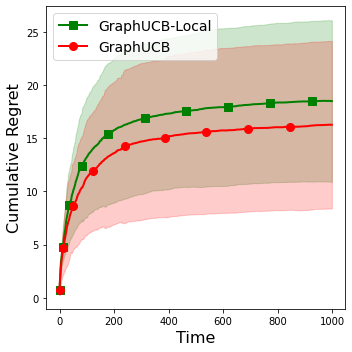

use v_inv in GUCB-local


In [26]:
x=range(iteration)
plt.figure(figsize=(5,5))
#plt.plot(x, linucb_mean, '-.', markevery=0.1, linewidth=2, markersize=8, label='LinUCB')
#plt.fill_between(x, linucb_mean-linucb_sd, linucb_mean+linucb_sd, color='b', alpha=0.2)
#plt.plot(x, gob_mean, '-p', color='orange', markevery=0.1, linewidth=2, markersize=8, label='Gob.Lin')
#plt.fill_between(x, gob_mean-gob_sd, gob_mean+gob_sd, color='orange', alpha=0.2)
plt.plot(x, lapucb_sim_mean, '-s', color='g', markevery=0.1, linewidth=2, markersize=8, label='GraphUCB-Local')
plt.fill_between(x, lapucb_sim_mean-lapucb_sim_sd, lapucb_sim_mean+lapucb_sim_sd, color='g', alpha=0.2)
plt.plot(x, lapucb_mean, '-o', color='r', markevery=0.1, linewidth=2, markersize=8, label='GraphUCB')
plt.fill_between(x, lapucb_mean-lapucb_sd, lapucb_mean+lapucb_sd, color='r', alpha=0.2)
#plt.plot(x, club_mean, '-*', color='k', markevery=0.1, linewidth=2, markersize=8, label='CLUB')
#plt.fill_between(x, club_mean-club_sd, club_mean+club_sd, color='k', alpha=0.2)
plt.ylabel('Cumulative Regret', fontsize=16)
plt.xlabel('Time', fontsize=16)
plt.legend(loc=2, fontsize=14)
plt.tight_layout()
#plt.savefig(save_path+'ws_cum_regret'+'.png', dpi=100)
plt.show()
print('use v_inv in GUCB-local')

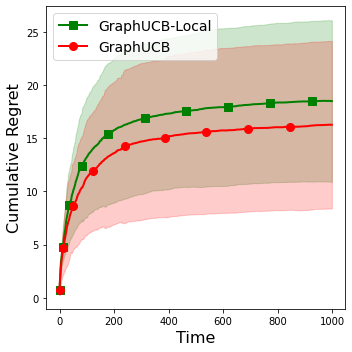

use xx_inv in GUCB-local


In [27]:
x=range(iteration)
plt.figure(figsize=(5,5))
#plt.plot(x, linucb_mean, '-.', markevery=0.1, linewidth=2, markersize=8, label='LinUCB')
#plt.fill_between(x, linucb_mean-linucb_sd, linucb_mean+linucb_sd, color='b', alpha=0.2)
#plt.plot(x, gob_mean, '-p', color='orange', markevery=0.1, linewidth=2, markersize=8, label='Gob.Lin')
#plt.fill_between(x, gob_mean-gob_sd, gob_mean+gob_sd, color='orange', alpha=0.2)
plt.plot(x, lapucb_sim_mean, '-s', color='g', markevery=0.1, linewidth=2, markersize=8, label='GraphUCB-Local')
plt.fill_between(x, lapucb_sim_mean-lapucb_sim_sd, lapucb_sim_mean+lapucb_sim_sd, color='g', alpha=0.2)
plt.plot(x, lapucb_mean, '-o', color='r', markevery=0.1, linewidth=2, markersize=8, label='GraphUCB')
plt.fill_between(x, lapucb_mean-lapucb_sd, lapucb_mean+lapucb_sd, color='r', alpha=0.2)
#plt.plot(x, club_mean, '-*', color='k', markevery=0.1, linewidth=2, markersize=8, label='CLUB')
#plt.fill_between(x, club_mean-club_sd, club_mean+club_sd, color='k', alpha=0.2)
plt.ylabel('Cumulative Regret', fontsize=16)
plt.xlabel('Time', fontsize=16)
plt.legend(loc=2, fontsize=14)
plt.tight_layout()
#plt.savefig(save_path+'ws_cum_regret'+'.png', dpi=100)
plt.show()
print('use xx_inv in GUCB-local')

# 6) Other algorithms

In [28]:
import scipy
from scipy.sparse import csgraph, csr_matrix
from scipy.sparse.csgraph import connected_components
import os 

## 6.1) CLUB

In [29]:
class CLUB():
    def __init__(self, dimension, iteration, user_num, item_num, pool_size, item_feature_matrix, true_user_feature_matrix, true_payoffs, alpha, alpha_2, delta, sigma, beta, state):
        self.state=state
        self.dimension=dimension
        self.iteration=iteration
        self.user_num=user_num
        self.item_num=item_num
        self.pool_size=pool_size
        self.item_feature_matrix=item_feature_matrix
        self.true_user_feature_matrix=true_user_feature_matrix
        self.true_payoffs=true_payoffs
        self.user_feature=np.zeros((self.user_num, self.dimension))
        self.I=np.identity(self.user_num)
        self.adj=np.ones((self.user_num, self.user_num))
        self.L=np.zeros((self.user_num, self.user_num))
        self.cluster_list=np.array(list(range(self.user_num)))
        self.cluster_num=0
        self.alpha=alpha
        self.alpha_2=alpha_2
        self.delta=delta
        self.sigma=sigma
        self.beta=beta
        self.beta_list=[]
        self.covariance={i: self.alpha*np.identity(self.dimension) for i in range(self.user_num)}
        self.bias=np.zeros((self.user_num, self.dimension))
        self.served_user_list=[]
        self.user_cluster_cov={i: np.identity(self.dimension) for i in range(self.user_num)}
        self.user_cluster_bias=np.zeros((self.user_num, self.dimension))
        self.user_cluster_feature=np.zeros((self.user_num, self.dimension))
        self.CBPrime = np.zeros(self.user_num)
        self.user_counters = np.zeros(self.user_num)

    def update_cluster_by_connected_components(self, user_index):
        self.cluster_num, self.cluster_list=connected_components(csr_matrix(self.adj))

    def update_graph(self, user_index):
        user_f_diff=np.linalg.norm(self.user_feature[user_index]-self.user_feature, axis=1)
        cb_prime_sum=self.CBPrime[user_index]+self.CBPrime
        ratio=user_f_diff/cb_prime_sum
        big_index=ratio>1.0
        self.adj[big_index, user_index]=0.0
        self.adj[user_index][big_index]=0.0

    def update_cluster_feature(self, user_index):
        user_cluster_index=self.cluster_list[user_index]
        all_users_in_the_cluster=list(np.where(self.cluster_list==user_cluster_index)[0])
        self.user_cluster_cov[user_index]=np.identity(self.dimension)
        self.user_cluster_bias[user_index]=np.zeros(self.dimension)
        for u in all_users_in_the_cluster:
            self.user_cluster_cov[user_index]+=self.covariance[u]-np.identity(self.dimension)
            self.user_cluster_bias[user_index]+=self.bias[u]

        new_cluster_feature=np.dot(np.linalg.pinv(self.user_cluster_cov[user_index]), self.user_cluster_bias[user_index])
        for u in all_users_in_the_cluster:
            self.user_cluster_feature[u]=new_cluster_feature

    def update_user_feature(self, true_payoff, selected_item_feature, user_index):
        self.covariance[user_index]+=np.outer(selected_item_feature, selected_item_feature)
        self.bias[user_index]+=true_payoff*selected_item_feature
        self.user_feature[user_index]=np.dot(np.linalg.pinv(self.covariance[user_index]), self.bias[user_index])
        self.CBPrime[user_index]=self.alpha_2*np.sqrt(float(1+np.log(1+self.user_counters[user_index])/float(1+self.user_counters[user_index])))
        self.user_counters[user_index]+=1

    def update_beta(self, user_index, time):
        cluster_cov=self.user_cluster_cov[user_index]
        cluster_cov_inv=np.linalg.pinv(cluster_cov)
        a=np.linalg.det(cluster_cov)**(1/2)
        b=np.linalg.det(self.alpha*np.identity(self.dimension))**(-1/2)
        self.beta=self.sigma*np.sqrt(2*np.log(a*b/self.delta))+np.sqrt(self.alpha)*np.linalg.norm(self.user_feature[user_index])
        self.beta=np.sqrt(self.alpha)+np.sqrt(2*np.log(1/self.delta)+self.dimension*np.log(1+self.iteration/(self.dimension*self.alpha)))

        self.beta_list.extend([self.beta])

    def select_item(self, user_index, item_pool, time):
        cluster_cov=self.user_cluster_cov[user_index]
        cluster_cov_inv=np.linalg.pinv(cluster_cov)
        est_payoffs=[]
        self.update_beta(user_index, time)
        for it in item_pool:
            x=self.item_feature_matrix[it]
            x_norm=np.sqrt(np.dot(np.dot(x, cluster_cov_inv), x))
            self.beta=0.1*np.sqrt(np.log(time+1))
            est_payoff=np.dot(self.user_cluster_feature[user_index], x)+self.beta*x_norm
            est_payoffs.extend([est_payoff])

        itt=np.argmax(est_payoffs)
        id_=item_pool[itt]
        selected_item_feature=self.item_feature_matrix[id_]
        true_payoff=self.true_payoffs[user_index, id_]+np.random.normal(scale=self.sigma)
        true_max_payoff=np.max(self.true_payoffs[user_index][item_pool])
        regret=true_max_payoff-true_payoff
        return true_payoff, regret, selected_item_feature, x_norm

    def run(self, user_array, item_pool_array, iteration):
        regret_error=[0]
        learning_error=[]
        cluster_num=[]
        x_norm_list=[]
        for time in range(iteration):
            #print('time/iteration', time, iteration, '~~~ CLUB')
            #### iteration 체크
            if time%100 == 0:
                print('time/iteration', time, iteration,'~~~CLUB')
            ####
            item_pool=item_pool_array[time]
            user_index=user_array[time]
            self.served_user_list.extend([user_index])
            self.served_user_list=list(np.unique(self.served_user_list))
            true_payoff, regret, selected_item_feature, x_norm=self.select_item(user_index, item_pool, time)
            x_norm_list.extend([x_norm])
            self.update_user_feature(true_payoff, selected_item_feature, user_index)
            self.update_graph(user_index)
            self.update_cluster_by_connected_components(user_index)
            self.update_cluster_feature(user_index)
            regret_error.extend([regret_error[-1]+regret])
            learning_error.extend([np.linalg.norm(self.true_user_feature_matrix-self.user_feature)])
            cluster_num.extend([self.cluster_num])
        return regret_error[1:], learning_error, cluster_num, self.beta_list, x_norm_list

## 6.2) LinUCB

In [30]:
class LINUCB():
    def __init__(self, dimension, iteration, user_num, item_num, pool_size, item_feature_matrix, true_user_feature_matrix, true_payoffs, alpha, delta, sigma, state):
        self.state=state
        self.dimension=dimension
        self.iteration=iteration
        self.user_num=user_num
        self.item_num=item_num
        self.pool_size=pool_size
        self.item_feature_matrix=item_feature_matrix
        self.true_user_feature_matrix=true_user_feature_matrix
        self.true_payoffs=true_payoffs
        self.user_feature=np.zeros((self.user_num, self.dimension))
        self.I=np.identity(self.dimension)
        self.alpha=alpha
        self.delta=delta
        self.sigma=sigma
        self.beta=0
        self.user_cov={}
        self.user_xx={}
        self.user_bias={}
        self.beta_list=[]
        self.real_beta_list=[]

    def initial_user_parameter(self):
        for u in range(self.user_num):
            self.user_cov[u]=self.alpha*np.identity(self.dimension)
            self.user_xx[u]=0.01*np.identity(self.dimension)
            self.user_bias[u]=np.zeros(self.dimension)

    def update_beta(self, user_index, time):
        a = np.linalg.det(self.user_cov[user_index])**(1/2)
        b = np.linalg.det(self.alpha*self.I)**(-1/2)
        self.beta=self.sigma*np.sqrt(2*np.log(a*b/self.delta))+np.sqrt(self.alpha)*np.linalg.norm(self.user_feature[user_index])
        #self.beta=np.sqrt(self.alpha)+np.sqrt(2*np.log(1/self.delta)+self.dimension*np.log(1+time/(self.dimension*self.alpha)))
        self.beta_list.extend([self.beta])
        real_beta=np.sqrt(np.dot(np.dot(self.user_feature[user_index]-self.true_user_feature_matrix[user_index], self.user_cov[user_index]),self.user_feature[user_index]-self.true_user_feature_matrix[user_index]))
        self.real_beta_list.extend([real_beta])

    def select_item(self, item_pool, user_index, time):
        item_fs=self.item_feature_matrix[item_pool]
        estimated_payoffs=np.zeros(self.pool_size)
        cov_inv=np.linalg.pinv(self.user_cov[user_index])
        self.update_beta(user_index, time)
        for j in range(self.pool_size):
            x=item_fs[j]
            x_norm=np.sqrt(np.dot(np.dot(x, cov_inv),x))
            est_y=np.dot(x, self.user_feature[user_index])+self.beta*x_norm
            estimated_payoffs[j]=est_y
            ucb=self.beta*x_norm

        max_index=np.argmax(estimated_payoffs)
        selected_item_index=item_pool[max_index]
        selected_item_feature=item_fs[max_index]
        true_payoff=self.true_payoffs[user_index, selected_item_index]+np.random.normal(scale=self.sigma)
        max_ideal_payoff=np.max(self.true_payoffs[user_index][item_pool])
        regret=max_ideal_payoff-true_payoff
        return true_payoff, selected_item_feature, regret, x_norm, ucb

    def update_user_feature(self, true_payoff, selected_item_feature, user_index):
        self.user_cov[user_index]+=np.outer(selected_item_feature, selected_item_feature)
        self.user_xx[user_index]+=np.outer(selected_item_feature, selected_item_feature)
        self.user_bias[user_index]+=true_payoff*selected_item_feature
        self.user_feature[user_index]=np.dot(np.linalg.pinv(self.user_cov[user_index]), self.user_bias[user_index])

    def run(self,user_array, item_pool_array, iteration):
        self.initial_user_parameter()
        cumulative_regret=[0]
        learning_error_list=[]
        x_norm_list=[]
        ucb_list=[]
        inst_regret=[]
        sum_x_norm=[0]
        for time in range(iteration):	
            #print('time/iteration', time, iteration,'~~~LinUCB')
            #### iteration 체크
            if time%100 == 0:
                print('time/iteration', time, iteration,'~~~LinUCB')
            ####
            user_index=user_array[time]
            item_pool=item_pool_array[time]
            true_payoff, selected_item_feature, regret, x_norm, ucb=self.select_item(item_pool, user_index, time)
            x_norm_list.extend([x_norm])
            self.update_user_feature(true_payoff, selected_item_feature, user_index)
            error=np.linalg.norm(self.user_feature-self.true_user_feature_matrix)
            cumulative_regret.extend([cumulative_regret[-1]+regret])
            learning_error_list.extend([error])
            inst_regret.extend([regret])
            ucb_list.extend([ucb])
            sum_x_norm.extend([sum_x_norm[-1]+x_norm])
        
        return cumulative_regret[1:], learning_error_list, self.beta_list, x_norm_list, inst_regret, ucb_list, sum_x_norm[1:], self.real_beta_list

## 6.3) GOB.Lin

In [31]:
class GOB():
    def __init__(self, dimension,iteration, user_num, item_num, pool_size, item_feature_matrix, true_user_feature_matrix, true_payoffs, true_adj, true_lap, alpha, delta, sigma, b, state):
        self.true_adj=true_adj
        self.state=state 
        self.dimension=dimension
        self.iteration=iteration
        self.user_num=user_num
        self.item_num=item_num
        self.pool_size=pool_size
        self.item_feature_matrix=item_feature_matrix
        self.true_user_feature_matrix=true_user_feature_matrix
        self.true_payoffs=true_payoffs
        self.true_user_feature_vector=true_user_feature_matrix.flatten()
        self.user_feature_vector=np.zeros(self.user_num*self.dimension)
        self.user_feature_matrix=np.zeros((self.user_num, self.dimension))
        self.user_feature_matrix_converted=np.zeros((self.user_num, self.dimension))
        self.user_ridge=np.zeros((self.user_num, self.dimension))
        self.user_ls=np.zeros((self.user_num, self.dimension))
        self.I=np.identity(self.user_num*self.dimension)
        self.adj=true_adj
        self.lap=true_lap
        self.L=self.lap.copy()+np.identity(self.user_num)
        self.A=np.kron(self.L, np.identity(self.dimension))
        self.A_inv=np.linalg.pinv(self.A)
        self.A_inv_sqrt=scipy.linalg.sqrtm(self.A_inv)
        self.alpha=alpha
        self.delta=delta
        self.sigma=sigma
        self.beta=0
        self.b=b
        self.covariance=np.identity(self.user_num*self.dimension)
        self.bias=np.zeros(self.user_num*self.dimension)
        self.beta_list=[]
        self.graph_error=[]
        self.user_xx={}
        self.user_v={}
        self.user_bias={}
        self.user_counter={}
        self.real_beta_list=[]

    def initial(self):
        for u in range(self.user_num):
            self.user_xx[u]=np.zeros((self.dimension, self.dimension))
            self.user_v[u]=self.alpha*np.identity(self.dimension)
            self.user_bias[u]=np.zeros(self.dimension)
            self.user_counter[u]=0

    def update_beta(self):
        a=np.linalg.det(self.covariance)
        #b=np.linalg.det(self.alpha*self.A)**(-1/2)
        self.beta=self.sigma*np.sqrt(np.log(a/self.delta))+np.sqrt(self.alpha)*np.linalg.norm(np.dot(np.real(self.A_inv_sqrt), self.user_feature_vector))
        self.beta_list.extend([self.beta])
        diff=self.user_feature_vector-self.true_user_feature_vector
        real_beta=np.sqrt(np.dot(np.dot(diff, self.covariance), diff))
        self.real_beta_list.extend([real_beta])
		
    def select_item(self, item_pool, user_index, time):
        item_fs=self.item_feature_matrix[item_pool]
        item_feature_array=np.zeros((self.pool_size, self.user_num*self.dimension))
        item_feature_array[:,user_index*self.dimension:(user_index+1)*self.dimension]=item_fs
        estimated_payoffs=np.zeros(self.pool_size)
        cov_inv=np.linalg.pinv(self.covariance)
        if self.state==False:
            self.update_beta()
            for j in range(self.pool_size):
                item_index=item_pool[j]
                x=self.item_feature_matrix[item_index]
                x_long=np.zeros((self.dimension*self.user_num))
                x_long[user_index*self.dimension:(user_index+1)*self.dimension]=x
                co_x=np.dot(self.A_inv_sqrt, x_long)
                x_norm=np.sqrt(np.dot(np.dot(co_x, cov_inv), co_x))
                self.beta=0.1*np.sqrt(np.log(time+1))
                est_y=np.dot(self.user_feature_vector, co_x)+self.beta*x_norm
                estimated_payoffs[j]=est_y
                ucb=self.beta_list[time]*x_norm
        else: 
            for j in range(self.pool_size):
                item_index=item_pool[j]
                x=self.item_feature_matrix[item_index]
                x_long=np.zeros((self.dimension*self.user_num))
                x_long[user_index*self.dimension:(user_index+1)*self.dimension]=x
                co_x=np.dot(np.real(self.A_inv_sqrt), x_long)
                x_norm=np.sqrt(np.dot(np.dot(co_x, cov_inv),co_x))
                est_y=np.dot(self.user_feature_vector, co_x)+self.beta*x_norm*np.sqrt(np.log(time+1))
                estimated_payoffs[j]=est_y
                ######### STATE = True이면 ucb가 정의가 안되어서 return시 에러발생한다######
                ucb = 0

        max_index=np.argmax(estimated_payoffs)
        selected_item_index=item_pool[max_index]
        selected_item_feature=item_fs[max_index]
        true_payoff=self.true_payoffs[user_index, selected_item_index]+np.random.normal(scale=self.sigma)
        max_ideal_payoff=np.max(self.true_payoffs[user_index][item_pool])
        regret=max_ideal_payoff-true_payoff
        return true_payoff, selected_item_feature, regret, x_norm, ucb

    def update_user_feature(self, true_payoff, selected_item_feature, user_index):
        x_long=np.zeros(self.dimension*self.user_num)
        x_long[user_index*self.dimension:(user_index+1)*self.dimension]=selected_item_feature
        co_x=np.dot(np.real(self.A_inv_sqrt), x_long)
        self.user_xx[user_index]+=np.outer(selected_item_feature, selected_item_feature)
        self.user_v[user_index]+=np.outer(selected_item_feature, selected_item_feature)
        self.user_bias[user_index]+=true_payoff*selected_item_feature
        self.covariance+=np.outer(co_x, co_x)
        self.bias+=true_payoff*co_x
        cov_inv=np.linalg.pinv(self.covariance)
        self.user_feature_vector=np.dot(cov_inv, self.bias)
        self.user_feature_matrix=self.user_feature_vector.reshape((self.user_num, self.dimension))
        self.user_feature_matrix_converted=np.dot(np.real(self.A_inv_sqrt),self.user_feature_vector).reshape((self.user_num, self.dimension))


    def run(self, user_array, item_pool_array, iteration):
        cumulative_regret=[0]
        learning_error_list=np.zeros(iteration)
        x_norm_list=[]
        sum_x_norm=[0]
        ucb_list=[]
        self.initial()		
        for time in range(iteration):	
            #print('time/iteration', time, iteration, '~~~GOB')
            #### iteration 체크
            if time%100 == 0:
                print('time/iteration', time, iteration,'~~~GOB')
            ####    
            user_index=user_array[time]
            item_pool=item_pool_array[time]
            self.user_counter[user_index]+=1
            true_payoff, selected_item_feature, regret, x_norm, ucb=self.select_item(item_pool, user_index, time)
            x_norm_list.extend([x_norm])
            ucb_list.extend([ucb])
            self.update_user_feature(true_payoff, selected_item_feature, user_index)
            cumulative_regret.extend([cumulative_regret[-1]+regret])
            error=np.linalg.norm(self.user_feature_matrix_converted.flatten()-self.true_user_feature_vector)
            learning_error_list[time]=error
            sum_x_norm.extend([sum_x_norm[-1]+x_norm])


        return np.array(cumulative_regret[1:]), learning_error_list, self.beta_list, x_norm_list, ucb_list, sum_x_norm[1:], self.real_beta_list

# 7) Run all algorithms

In [32]:
linucb_regret_matrix=np.zeros((loop, iteration))
linucb_error_matrix=np.zeros((loop, iteration))
gob_regret_matrix=np.zeros((loop, iteration))
gob_error_matrix=np.zeros((loop, iteration))
lapucb_regret_matrix=np.zeros((loop, iteration))
lapucb_error_matrix=np.zeros((loop, iteration))
lapucb_sim_regret_matrix=np.zeros((loop, iteration))
lapucb_sim_error_matrix=np.zeros((loop, iteration))
club_regret_matrix=np.zeros((loop, iteration))
club_error_matrix=np.zeros((loop, iteration))

In [33]:
for ell in range(loop):
    print('start', ell + 1,'/', loop, 'loop')
    user_feature_matrix=dictionary_matrix_generator(user_num, dimension, true_lap, 7)
    # smooth Theta : use eq19 // last parameter controls the smoothness
    
    true_payoffs=np.dot(user_feature_matrix, item_feature_matrix.T) # as matrix
        
    lapucb_model=LAPUCB(dimension, iteration, user_num, item_num, pool_size, item_feature_matrix, user_feature_matrix, true_payoffs, true_adj, true_lap, alpha, delta, sigma, beta, thres, 1)
    lapucb_regret, lapucb_error, lapucb_beta, lapucb_x_norm, lapucb_inst_regret, lapucb_ucb, lapucb_sum_x_norm, lapucb_real_beta=lapucb_model.run(user_seq, item_pool_seq, iteration)
    lapucb_regret_matrix[ell], lapucb_error_matrix[ell]=lapucb_regret, lapucb_error

    lapucb_sim_model=LAPUCB_SIM(dimension, iteration, user_num, item_num, pool_size, item_feature_matrix, user_feature_matrix, true_payoffs, true_adj, true_lap, alpha, delta, sigma, beta, thres, 1)
    lapucb_sim_regret, lapucb_sim_error, lapucb_sim_beta, lapucb_sim_x_norm, lapucb_sim_avg_norm, lapucb_sim_inst_regret, lapucb_sim_ucb, lapucb_sim_sum_x_norm=lapucb_sim_model.run( user_seq, item_pool_seq, iteration)
    lapucb_sim_regret_matrix[ell], lapucb_sim_error_matrix[ell]=lapucb_sim_regret, lapucb_sim_error   
        
    linucb_model=LINUCB(dimension, iteration, user_num, item_num, pool_size, item_feature_matrix, user_feature_matrix, true_payoffs, alpha, delta, sigma, state)
    linucb_regret, linucb_error, linucb_beta, linucb_x_norm, linucb_inst_regret, linucb_ucb, linucb_sum_x_norm, linucb_real_beta=linucb_model.run(user_seq, item_pool_seq, iteration)
    linucb_regret_matrix[ell], linucb_error_matrix[ell]=linucb_regret, linucb_error

    gob_model=GOB(dimension, iteration, user_num, item_num, pool_size, item_feature_matrix, user_feature_matrix, true_payoffs, true_adj, true_lap, alpha, delta, sigma, beta, state)
    gob_regret, gob_error, gob_beta,  gob_x_norm, gob_ucb, gob_sum_x_norm, gob_real_beta=gob_model.run(user_seq, item_pool_seq, iteration)
    gob_regret_matrix[ell], gob_error_matrix[ell]=gob_regret, gob_error

    club_model = CLUB(dimension, iteration, user_num, item_num, pool_size, item_feature_matrix, user_feature_matrix, true_payoffs, alpha, alpha_2, delta, sigma, beta, state)
    club_regret, club_error,club_cluster_num, club_beta, club_x_norm=club_model.run(user_seq, item_pool_seq, iteration)
    club_regret_matrix[ell], club_error_matrix[ell]=club_regret, club_error

    print('end ', ell+1,'/', loop, 'loop')
    print('------------------------------------')

print('done')

start 1 / 10 loop
time/iteration 0 1000 ~~~GraphUCB
time/iteration 100 1000 ~~~GraphUCB
time/iteration 200 1000 ~~~GraphUCB
time/iteration 300 1000 ~~~GraphUCB
time/iteration 400 1000 ~~~GraphUCB
time/iteration 500 1000 ~~~GraphUCB
time/iteration 600 1000 ~~~GraphUCB
time/iteration 700 1000 ~~~GraphUCB
time/iteration 800 1000 ~~~GraphUCB
time/iteration 900 1000 ~~~GraphUCB
time/iteration 0 1000 ~~~GraphUCB-Local
time/iteration 100 1000 ~~~GraphUCB-Local
time/iteration 200 1000 ~~~GraphUCB-Local
time/iteration 300 1000 ~~~GraphUCB-Local
time/iteration 400 1000 ~~~GraphUCB-Local
time/iteration 500 1000 ~~~GraphUCB-Local
time/iteration 600 1000 ~~~GraphUCB-Local
time/iteration 700 1000 ~~~GraphUCB-Local
time/iteration 800 1000 ~~~GraphUCB-Local
time/iteration 900 1000 ~~~GraphUCB-Local
time/iteration 0 1000 ~~~LinUCB
time/iteration 100 1000 ~~~LinUCB
time/iteration 200 1000 ~~~LinUCB
time/iteration 300 1000 ~~~LinUCB
time/iteration 400 1000 ~~~LinUCB
time/iteration 500 1000 ~~~LinUCB
time

In [34]:
lapucb_mean=np.mean(lapucb_regret_matrix, axis=0)
lapucb_sd=lapucb_regret_matrix.std(0)

lapucb_sim_mean=np.mean(lapucb_sim_regret_matrix, axis=0)
lapucb_sim_sd=lapucb_sim_regret_matrix.std(0)

linucb_mean=np.mean(linucb_regret_matrix, axis=0)
linucb_sd=linucb_regret_matrix.std(0)

gob_mean=np.mean(gob_regret_matrix, axis=0)
gob_sd=gob_regret_matrix.std(0)

club_mean=np.mean(club_regret_matrix, axis=0)
club_sd=club_regret_matrix.std(0)

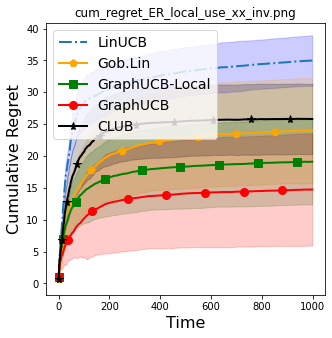

In [35]:
x=range(iteration)
image = plt.figure(figsize=(5,5))
plt.plot(x, linucb_mean, '-.', markevery=0.1, linewidth=2, markersize=8, label='LinUCB')
plt.fill_between(x, linucb_mean-linucb_sd, linucb_mean+linucb_sd, color='b', alpha=0.2)
plt.plot(x, gob_mean, '-p', color='orange', markevery=0.1, linewidth=2, markersize=8, label='Gob.Lin')
plt.fill_between(x, gob_mean-gob_sd, gob_mean+gob_sd, color='orange', alpha=0.2)
plt.plot(x, lapucb_sim_mean, '-s', color='g', markevery=0.1, linewidth=2, markersize=8, label='GraphUCB-Local')
plt.fill_between(x, lapucb_sim_mean-lapucb_sim_sd, lapucb_sim_mean+lapucb_sim_sd, color='g', alpha=0.2)
plt.plot(x, lapucb_mean, '-o', color='r', markevery=0.1, linewidth=2, markersize=8, label='GraphUCB')
plt.fill_between(x, lapucb_mean-lapucb_sd, lapucb_mean+lapucb_sd, color='r', alpha=0.2)
plt.plot(x, club_mean, '-*', color='k', markevery=0.1, linewidth=2, markersize=8, label='CLUB')
plt.fill_between(x, club_mean-club_sd, club_mean+club_sd, color='k', alpha=0.2)
plt.ylabel('Cumulative Regret', fontsize=16)
plt.xlabel('Time', fontsize=16)
plt.legend(loc=2, fontsize=14)
#plt.tight_layout()

figure_name = 'cum_regret_' + 'ER' + '_local_use_' + 'xx' + '_inv' + '.png'
plt.title(figure_name)
#plt.savefig(figure_name, dpi=200)
plt.show()
# files.download(figure_name) 

# The codes below this line need to be fixed.
# =======================================
Issue for negative values of V, which is an item feature matrix.

In [36]:
from google.colab import drive
drive.mount('/content/gdrive') 

Mounted at /content/gdrive


In [37]:
%cd /content/gdrive

/content/gdrive


In [38]:
cd 'My Drive/Colab Notebooks/GraphUCB'

/content/gdrive/My Drive/Colab Notebooks/GraphUCB


# 8) MovieLens dataset
https://grouplens.org/datasets/movielens/1m/

## 8.1) Setting : 그런데 state의 상태가?

In [45]:
movielens_path = './RealData/movielens_optspace/'
U = np.load(movielens_path + 'U_user_4_sure.npy')
V = np.load(movielens_path + 'V_user_4_sure.npy')
print(U.shape)
print(V.shape)
total_user = U.shape[0]
total_movie = V.shape[0]

(6040, 10)
(3706, 10)


In [46]:
any = 2000
print(np.linalg.norm(U[any]))
print(np.linalg.norm(V[any]))

5.5203092364244535
1.2163389186075633


In [62]:
user_num=20
item_num=300
dimension=10
pool_size=20
iteration=1000
loop=10
sigma=0.01# noise
delta=0.01# high probability
alpha=1# regularizer
alpha_2=0.15# edge delete CLUB
beta=0.125 # exploration for CLUB, SCLUB and GOB
state=False # False for artificial dataset, True for real dataset
thres=0

In [66]:
# run_artificial.py setting
# user_num=10
# item_num=500
# dimension=5
# pool_size=50
# iteration=1000
# loop=10
# sigma=0.01 # noise
# delta=0.01 # high probability
# alpha=1 # regularizer
# alpha_2=0.15 # edge delete CLUB
# epsilon=8 # Ts
# beta=0.125 # exploration for CLUB, SCLUB and GOB
# thres=0.0
# state=False # False for artificial dataset, True for real dataset
#################
#################
# run_movielens.py setting
# user_num=20
# item_num=300
# dimension=10
# pool_size=20
# iteration=1000
# loop=5
# sigma=0.01# noise
# delta=0.01# high probability
# alpha=0.25# regularizer
# alpha_2=0.125# edge delete CLUB
# beta=0.25 # exploration for CLUB, SCLUB and GOB
# state=False # False for artificial dataset, True for real dataset
# thres=0

In [82]:
user_feature_matrix_ori = Normalizer().fit_transform(U)
item_feature_matrix_ori = Normalizer().fit_transform(V)
user_length=user_feature_matrix_ori.shape[0]
item_length=item_feature_matrix_ori.shape[0]

In [103]:
temp = (V>0)
count = 0
for i in range(temp.shape[0]):
    for j in range(temp.shape[1]):
        if temp[i][j] == True:
            count+=1

print(count)
print(temp.size) 
print(np.dot(U[0], V[0]))

7925
37060
3.285003749839327


In [83]:
linucb_regret_matrix=np.zeros((loop, iteration))
linucb_error_matrix=np.zeros((loop, iteration))
gob_regret_matrix=np.zeros((loop, iteration))
gob_error_matrix=np.zeros((loop, iteration))
lapucb_regret_matrix=np.zeros((loop, iteration))
lapucb_error_matrix=np.zeros((loop, iteration))
lapucb_sim_regret_matrix=np.zeros((loop, iteration))
lapucb_sim_error_matrix=np.zeros((loop, iteration))
club_regret_matrix=np.zeros((loop, iteration))
club_error_matrix=np.zeros((loop, iteration))
####
#gob_graph_matrix=np.zeros((loop, iteration))
#lapucb_graph_matrix=np.zeros((loop, iteration))
#lapucb_sim_graph_matrix=np.zeros((loop, iteration))

In [86]:
for l in range(loop):
    print('loop/total_loop', l, loop)
    user_list = np.random.choice(range(user_length), size=user_num)
    item_list = np.random.choice(range(item_length), size=item_num)
 
    user_feature_matrix = user_feature_matrix_ori[user_list]
    item_feature_matrix = item_feature_matrix_ori[item_list]
    noise_matrix=np.random.normal(scale=sigma, size=(user_num, item_num))
 
    true_payoffs = np.dot(user_feature_matrix, item_feature_matrix.T)+noise_matrix
    user_seq = np.random.choice(range(user_num), size=iteration)
    item_pool_seq = np.random.choice(range(item_num), size=(iteration, pool_size))

    true_adj=rbf_kernel(user_feature_matrix, gamma=2)
    true_adj[true_adj<0.5]=0 #threshold
    np.fill_diagonal(true_adj,0)
    
    # Laplacian 구하기
    D=np.diag(np.sum(true_adj, axis=1))
    true_lap=np.zeros((user_num, user_num))
    for i in range(user_num):
        for j in range(user_num):
            if D[i,i]==0:
                true_lap[i,j]=0
            else:
                true_lap[i,j]=-true_adj[i,j]/D[i,i]

    np.fill_diagonal(true_lap, 1)

    linucb_model=LINUCB(dimension, iteration, user_num, item_num, pool_size, item_feature_matrix, user_feature_matrix, true_payoffs, alpha, delta, sigma, state)
    gob_model=GOB(dimension, iteration, user_num, item_num, pool_size, item_feature_matrix, user_feature_matrix, true_payoffs, true_adj, true_lap, alpha, delta, sigma, beta, state)
    lapucb_model=LAPUCB(dimension, iteration, user_num, item_num, pool_size, item_feature_matrix, user_feature_matrix, true_payoffs, true_adj, true_lap, alpha, delta, sigma, beta, thres, 1)
    lapucb_sim_model=LAPUCB_SIM(dimension, iteration, user_num, item_num, pool_size, item_feature_matrix, user_feature_matrix, true_payoffs, true_adj, true_lap, alpha, delta, sigma, beta, thres, 1)
    club_model = CLUB(dimension, iteration, user_num, item_num, pool_size, item_feature_matrix, user_feature_matrix, true_payoffs, alpha, alpha_2, delta, sigma, beta, state)

    linucb_regret, linucb_error, linucb_beta, linucb_x_norm, linucb_inst_regret, linucb_ucb, linucb_sum_x_norm, linucb_real_beta=linucb_model.run(user_seq, item_pool_seq, iteration)
    gob_regret, gob_error, gob_beta,  gob_x_norm, gob_ucb, gob_sum_x_norm, gob_real_beta=gob_model.run(user_seq, item_pool_seq, iteration)
    lapucb_regret, lapucb_error, lapucb_beta, lapucb_x_norm, lapucb_inst_regret, lapucb_ucb, lapucb_sum_x_norm, lapucb_real_beta=lapucb_model.run(user_seq, item_pool_seq, iteration)
    lapucb_sim_regret, lapucb_sim_error, lapucb_sim_beta, lapucb_sim_x_norm, lapucb_sim_avg_norm, lapucb_sim_inst_regret, lapucb_sim_ucb, lapucb_sim_sum_x_norm=lapucb_sim_model.run( user_seq, item_pool_seq, iteration)
    club_regret, club_error,club_cluster_num, club_beta, club_x_norm=club_model.run(user_seq, item_pool_seq, iteration)

    linucb_regret_matrix[l], linucb_error_matrix[l]=linucb_regret, linucb_error
    gob_regret_matrix[l], gob_error_matrix[l]=gob_regret, gob_error
    lapucb_regret_matrix[l], lapucb_error_matrix[l]=lapucb_regret, lapucb_error
    lapucb_sim_regret_matrix[l], lapucb_sim_error_matrix[l]=lapucb_sim_regret, lapucb_sim_error
    club_regret_matrix[l], club_error_matrix[l]=club_regret, club_error



loop/total_loop 0 10
time/iteration 0 1000 ~~~LinUCB
time/iteration 100 1000 ~~~LinUCB
time/iteration 200 1000 ~~~LinUCB
time/iteration 300 1000 ~~~LinUCB
time/iteration 400 1000 ~~~LinUCB
time/iteration 500 1000 ~~~LinUCB
time/iteration 600 1000 ~~~LinUCB
time/iteration 700 1000 ~~~LinUCB
time/iteration 800 1000 ~~~LinUCB
time/iteration 900 1000 ~~~LinUCB
time/iteration 0 1000 ~~~GOB


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: ComplexWarning: Casting complex values to real discards the imaginary part


time/iteration 100 1000 ~~~GOB
time/iteration 200 1000 ~~~GOB
time/iteration 300 1000 ~~~GOB
time/iteration 400 1000 ~~~GOB
time/iteration 500 1000 ~~~GOB
time/iteration 600 1000 ~~~GOB
time/iteration 700 1000 ~~~GOB
time/iteration 800 1000 ~~~GOB
time/iteration 900 1000 ~~~GOB
time/iteration 0 1000 ~~~GraphUCB
time/iteration 100 1000 ~~~GraphUCB
time/iteration 200 1000 ~~~GraphUCB
time/iteration 300 1000 ~~~GraphUCB
time/iteration 400 1000 ~~~GraphUCB
time/iteration 500 1000 ~~~GraphUCB
time/iteration 600 1000 ~~~GraphUCB
time/iteration 700 1000 ~~~GraphUCB
time/iteration 800 1000 ~~~GraphUCB
time/iteration 900 1000 ~~~GraphUCB
time/iteration 0 1000 ~~~GraphUCB-Local
time/iteration 100 1000 ~~~GraphUCB-Local
time/iteration 200 1000 ~~~GraphUCB-Local
time/iteration 300 1000 ~~~GraphUCB-Local
time/iteration 400 1000 ~~~GraphUCB-Local
time/iteration 500 1000 ~~~GraphUCB-Local
time/iteration 600 1000 ~~~GraphUCB-Local
time/iteration 700 1000 ~~~GraphUCB-Local
time/iteration 800 1000 ~~~Gr

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: ComplexWarning: Casting complex values to real discards the imaginary part


time/iteration 100 1000 ~~~GOB
time/iteration 200 1000 ~~~GOB
time/iteration 300 1000 ~~~GOB
time/iteration 400 1000 ~~~GOB
time/iteration 500 1000 ~~~GOB
time/iteration 600 1000 ~~~GOB
time/iteration 700 1000 ~~~GOB
time/iteration 800 1000 ~~~GOB
time/iteration 900 1000 ~~~GOB
time/iteration 0 1000 ~~~GraphUCB
time/iteration 100 1000 ~~~GraphUCB
time/iteration 200 1000 ~~~GraphUCB
time/iteration 300 1000 ~~~GraphUCB
time/iteration 400 1000 ~~~GraphUCB
time/iteration 500 1000 ~~~GraphUCB
time/iteration 600 1000 ~~~GraphUCB
time/iteration 700 1000 ~~~GraphUCB
time/iteration 800 1000 ~~~GraphUCB
time/iteration 900 1000 ~~~GraphUCB
time/iteration 0 1000 ~~~GraphUCB-Local
time/iteration 100 1000 ~~~GraphUCB-Local
time/iteration 200 1000 ~~~GraphUCB-Local
time/iteration 300 1000 ~~~GraphUCB-Local
time/iteration 400 1000 ~~~GraphUCB-Local
time/iteration 500 1000 ~~~GraphUCB-Local
time/iteration 600 1000 ~~~GraphUCB-Local
time/iteration 700 1000 ~~~GraphUCB-Local
time/iteration 800 1000 ~~~Gr

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: ComplexWarning: Casting complex values to real discards the imaginary part


time/iteration 100 1000 ~~~GOB
time/iteration 200 1000 ~~~GOB
time/iteration 300 1000 ~~~GOB
time/iteration 400 1000 ~~~GOB
time/iteration 500 1000 ~~~GOB
time/iteration 600 1000 ~~~GOB
time/iteration 700 1000 ~~~GOB
time/iteration 800 1000 ~~~GOB
time/iteration 900 1000 ~~~GOB
time/iteration 0 1000 ~~~GraphUCB
time/iteration 100 1000 ~~~GraphUCB
time/iteration 200 1000 ~~~GraphUCB
time/iteration 300 1000 ~~~GraphUCB
time/iteration 400 1000 ~~~GraphUCB
time/iteration 500 1000 ~~~GraphUCB
time/iteration 600 1000 ~~~GraphUCB
time/iteration 700 1000 ~~~GraphUCB
time/iteration 800 1000 ~~~GraphUCB
time/iteration 900 1000 ~~~GraphUCB
time/iteration 0 1000 ~~~GraphUCB-Local
time/iteration 100 1000 ~~~GraphUCB-Local
time/iteration 200 1000 ~~~GraphUCB-Local
time/iteration 300 1000 ~~~GraphUCB-Local
time/iteration 400 1000 ~~~GraphUCB-Local
time/iteration 500 1000 ~~~GraphUCB-Local
time/iteration 600 1000 ~~~GraphUCB-Local
time/iteration 700 1000 ~~~GraphUCB-Local
time/iteration 800 1000 ~~~Gr

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: ComplexWarning: Casting complex values to real discards the imaginary part


time/iteration 100 1000 ~~~GOB
time/iteration 200 1000 ~~~GOB
time/iteration 300 1000 ~~~GOB
time/iteration 400 1000 ~~~GOB
time/iteration 500 1000 ~~~GOB
time/iteration 600 1000 ~~~GOB
time/iteration 700 1000 ~~~GOB
time/iteration 800 1000 ~~~GOB
time/iteration 900 1000 ~~~GOB
time/iteration 0 1000 ~~~GraphUCB
time/iteration 100 1000 ~~~GraphUCB
time/iteration 200 1000 ~~~GraphUCB
time/iteration 300 1000 ~~~GraphUCB
time/iteration 400 1000 ~~~GraphUCB
time/iteration 500 1000 ~~~GraphUCB
time/iteration 600 1000 ~~~GraphUCB
time/iteration 700 1000 ~~~GraphUCB
time/iteration 800 1000 ~~~GraphUCB
time/iteration 900 1000 ~~~GraphUCB
time/iteration 0 1000 ~~~GraphUCB-Local
time/iteration 100 1000 ~~~GraphUCB-Local
time/iteration 200 1000 ~~~GraphUCB-Local
time/iteration 300 1000 ~~~GraphUCB-Local
time/iteration 400 1000 ~~~GraphUCB-Local
time/iteration 500 1000 ~~~GraphUCB-Local
time/iteration 600 1000 ~~~GraphUCB-Local
time/iteration 700 1000 ~~~GraphUCB-Local
time/iteration 800 1000 ~~~Gr

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: ComplexWarning: Casting complex values to real discards the imaginary part


time/iteration 100 1000 ~~~GOB
time/iteration 200 1000 ~~~GOB
time/iteration 300 1000 ~~~GOB
time/iteration 400 1000 ~~~GOB
time/iteration 500 1000 ~~~GOB
time/iteration 600 1000 ~~~GOB
time/iteration 700 1000 ~~~GOB
time/iteration 800 1000 ~~~GOB
time/iteration 900 1000 ~~~GOB
time/iteration 0 1000 ~~~GraphUCB
time/iteration 100 1000 ~~~GraphUCB
time/iteration 200 1000 ~~~GraphUCB
time/iteration 300 1000 ~~~GraphUCB
time/iteration 400 1000 ~~~GraphUCB
time/iteration 500 1000 ~~~GraphUCB
time/iteration 600 1000 ~~~GraphUCB
time/iteration 700 1000 ~~~GraphUCB
time/iteration 800 1000 ~~~GraphUCB
time/iteration 900 1000 ~~~GraphUCB
time/iteration 0 1000 ~~~GraphUCB-Local
time/iteration 100 1000 ~~~GraphUCB-Local
time/iteration 200 1000 ~~~GraphUCB-Local
time/iteration 300 1000 ~~~GraphUCB-Local
time/iteration 400 1000 ~~~GraphUCB-Local
time/iteration 500 1000 ~~~GraphUCB-Local
time/iteration 600 1000 ~~~GraphUCB-Local
time/iteration 700 1000 ~~~GraphUCB-Local
time/iteration 800 1000 ~~~Gr

In [88]:
linucb_regret=np.mean(linucb_regret_matrix, axis=0)
linucb_error=np.mean(linucb_error_matrix, axis=0)

gob_regret=np.mean(gob_regret_matrix, axis=0)
gob_error=np.mean(gob_error_matrix, axis=0)

lapucb_regret=np.mean(lapucb_regret_matrix, axis=0)
lapucb_error=np.mean(lapucb_error_matrix, axis=0)

lapucb_sim_regret=np.mean(lapucb_sim_regret_matrix, axis=0)
lapucb_sim_error=np.mean(lapucb_sim_error_matrix, axis=0)

club_regret=np.mean(club_regret_matrix, axis=0)
club_error=np.mean(club_error_matrix, axis=0)

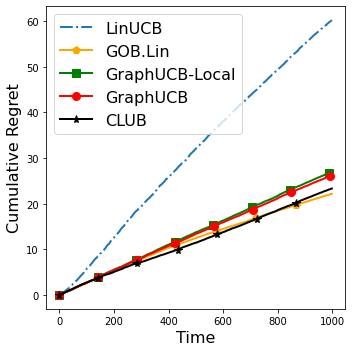

In [89]:
plt.figure(figsize=(5,5))
plt.plot(linucb_regret,'-.', markevery=0.1, linewidth=2, markersize=8, label='LinUCB')
plt.plot(gob_regret, '-p', color='orange', markevery=0.1,linewidth=2, markersize=8, label='GOB.Lin')
plt.plot(lapucb_sim_regret, '-s', color='g', markevery=0.1,linewidth=2, markersize=8, label='GraphUCB-Local')
plt.plot(lapucb_regret, '-o', color='r', markevery=0.1,linewidth=2, markersize=8, label='GraphUCB')
plt.plot(club_regret,'-*',color='k',  markevery=0.1,linewidth=2, markersize=8, label='CLUB')
plt.ylabel('Cumulative Regret', fontsize=16)
plt.xlabel('Time', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.tight_layout()
#plt.savefig(path+'movielens_backup'+'.png', dpi=100)
plt.show()

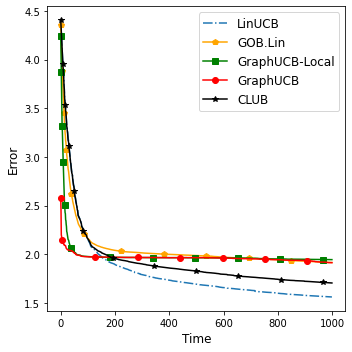

In [90]:
plt.figure(figsize=(5,5))
plt.plot(linucb_error,'-.', markevery=0.1, label='LinUCB')
plt.plot(gob_error, '-p', color='orange', markevery=0.1, label='GOB.Lin')
plt.plot(lapucb_sim_error, '-s',color='g',  markevery=0.1, label='GraphUCB-Local')
plt.plot(lapucb_error, '-o',color='r',  markevery=0.1, label='GraphUCB')
plt.plot(club_error, '-*', color='k', markevery=0.1,  label='CLUB')
plt.ylabel('Error', fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.legend(loc=1, fontsize=12)
plt.tight_layout()
#plt.savefig(path+'error'+'.png', dpi=100)
plt.show()

U에서는 user_num만큼, V에서는 item_num만큼 선택한다.

In [47]:
np.random.seed(2020)
our_user = np.random.choice(np.arange(total_user), size = user_num, replace = False)
our_movie = np.random.choice(np.arange(total_movie), size = item_num, replace = False)
print(our_user[:5])
print(our_movie[:5])

[1172 2358 1753  914 2973]
[1709   29 1945 1089 1112]


In [48]:
U_small = U[our_user]
V_small = V[our_movie]
print(U_small.shape)
print(V_small.shape)

(20, 10)
(300, 10)


In [55]:
#normalize를 안하니까 그래프가 이상한가?
U_small = Normalizer().fit_transform(U_small)
V_small = Normalizer().fit_transform(V_small)
print(np.linalg.norm(U_small[2]))
print(np.linalg.norm(V_small[2]))

1.0
1.0


U_small로부터 RBF를 만든다.  
나머지 처리는 artificial case와 동일하게.  


In [64]:
movielens_rbf = rbf_kernel(U_small, gamma=0.8) # gamma : 논문의 rho에 해당
movielens_rbf[movielens_rbf<0.5]=0 #threshold
np.fill_diagonal(movielens_rbf, 0)
print(movielens_rbf.shape)
#print(np.round(movielens_rbf,3))
a = movielens_rbf.shape[0]**2
b = np.count_nonzero(movielens_rbf)
c = sum(sum(movielens_rbf))
print('RBF info.')
print('(1)size:', a, '(2)nonzero:', b, '(3)nonzero(%):', np.round(100*b/a, 1))
print('(4)norm:', np.round(np.linalg.norm(movielens_rbf), 3), '(5)sum of nnz:', np.round(c, 3), '(6)nnz_average:', np.round(c/b, 3))

(20, 20)
RBF info.
(1)size: 400 (2)nonzero: 236 (3)nonzero(%): 59.0
(4)norm: 13.192 (5)sum of nnz: 198.915 (6)nnz_average: 0.843


RBF에서 nonzeros의 average가 1에 가깝다는 특징.  
feture vector가 매우 비슷하거나 매우 안비슷하다는 해석?

In [65]:
#Laplacian
D=np.diag(np.sum(movielens_rbf, axis=1))
true_lap=np.zeros((user_num, user_num))
# random walk Laplacian
for i in range(user_num):
	for j in range(user_num):
		if D[i,i]==0:
			true_lap[i,j]=0
		else:
			true_lap[i,j]= -movielens_rbf[i,j]/D[i,i]
np.fill_diagonal(true_lap, 1)
#print(np.round(true_lap,3))

In [66]:
user_feature_matrix = U_small
item_feature_matrix = V_small

In [51]:
#######대체왤까#######
np.random.seed(1234)
np.random.seed(5678)
er_adj=ER_graph(user_num, 0.4)
#print(er_adj)

true_adj=er_adj.copy()

D=np.diag(np.sum(true_adj, axis=1))
true_lap=np.zeros((user_num, user_num))
# random walk Laplacian
for i in range(user_num):
	for j in range(user_num):
		if D[i,i]==0:
			true_lap[i,j]=0
		else:
			true_lap[i,j]=-true_adj[i,j]/D[i,i]
np.fill_diagonal(true_lap, 1)
#print(np.round(true_lap,3))

user_seq=np.random.choice(range(user_num), size=iteration) # randomly choose users : 1~T까지 미리 정함
item_pool_seq=np.random.choice(range(item_num), size=(iteration, pool_size)) 
item_feature_matrix=Normalizer().fit_transform(np.random.normal(size=(item_num, dimension)))

print(er_adj.shape)
#print(np.round(movielens_rbf,3))
a = er_adj.shape[0]**2
b = np.count_nonzero(er_adj)
c = sum(sum(er_adj))
print('ER-adj info.')
print('(1)size:', a, '(2)nonzero:', b, '(3)nonzero(%):', np.round(100*b/a, 1))
print('(4)norm:', np.round(np.linalg.norm(er_adj), 3), '(5)sum of nnz:', np.round(c, 3), '(6)nnz_average:', np.round(c/b, 3))

(20, 20)
ER-adj info.
(1)size: 400 (2)nonzero: 132 (3)nonzero(%): 33.0
(4)norm: 11.489 (5)sum of nnz: 132.0 (6)nnz_average: 1.0


In [67]:
linucb_regret_matrix=np.zeros((loop, iteration))
linucb_error_matrix=np.zeros((loop, iteration))
gob_regret_matrix=np.zeros((loop, iteration))
gob_error_matrix=np.zeros((loop, iteration))
lapucb_regret_matrix=np.zeros((loop, iteration))
lapucb_error_matrix=np.zeros((loop, iteration))
lapucb_sim_regret_matrix=np.zeros((loop, iteration))
lapucb_sim_error_matrix=np.zeros((loop, iteration))
club_regret_matrix=np.zeros((loop, iteration))
club_error_matrix=np.zeros((loop, iteration))

In [68]:
true_adj = movielens_rbf.copy()

In [69]:
user_seq = np.random.choice(range(user_num), size=iteration)
item_pool_seq = np.random.choice(range(item_num), size=(iteration, pool_size))

In [70]:
start00 = time.time()
for ell in range(loop):
    print('start', ell + 1,'/', loop, 'loop')
    start = time.time()

    # user_feature_matrix=dictionary_matrix_generator(user_num, dimension, true_lap, 7)

    true_payoffs=np.dot(user_feature_matrix, item_feature_matrix.T) # as matrix
    #user_seq = np.random.choice(range(user_num), size=iteration)
    #item_pool_seq = np.random.choice(range(item_num), size=(iteration, pool_size))
        
    lapucb_model=LAPUCB(dimension, iteration, user_num, item_num, pool_size, item_feature_matrix, user_feature_matrix, true_payoffs, true_adj, true_lap, alpha, delta, sigma, beta, thres, 1)
    lapucb_regret, lapucb_error, lapucb_beta, lapucb_x_norm, lapucb_inst_regret, lapucb_ucb, lapucb_sum_x_norm, lapucb_real_beta=lapucb_model.run(user_seq, item_pool_seq, iteration)
    lapucb_regret_matrix[ell], lapucb_error_matrix[ell]=lapucb_regret, lapucb_error

    lapucb_sim_model=LAPUCB_SIM(dimension, iteration, user_num, item_num, pool_size, item_feature_matrix, user_feature_matrix, true_payoffs, true_adj, true_lap, alpha, delta, sigma, beta, thres, 1)
    lapucb_sim_regret, lapucb_sim_error, lapucb_sim_beta, lapucb_sim_x_norm, lapucb_sim_avg_norm, lapucb_sim_inst_regret, lapucb_sim_ucb, lapucb_sim_sum_x_norm=lapucb_sim_model.run( user_seq, item_pool_seq, iteration)
    lapucb_sim_regret_matrix[ell], lapucb_sim_error_matrix[ell]=lapucb_sim_regret, lapucb_sim_error   
        
    linucb_model=LINUCB(dimension, iteration, user_num, item_num, pool_size, item_feature_matrix, user_feature_matrix, true_payoffs, alpha, delta, sigma, state)
    linucb_regret, linucb_error, linucb_beta, linucb_x_norm, linucb_inst_regret, linucb_ucb, linucb_sum_x_norm, linucb_real_beta=linucb_model.run(user_seq, item_pool_seq, iteration)
    linucb_regret_matrix[ell], linucb_error_matrix[ell]=linucb_regret, linucb_error

    gob_model=GOB(dimension, iteration, user_num, item_num, pool_size, item_feature_matrix, user_feature_matrix, true_payoffs, true_adj, true_lap, alpha, delta, sigma, beta, state)
    gob_regret, gob_error, gob_beta,  gob_x_norm, gob_ucb, gob_sum_x_norm, gob_real_beta=gob_model.run(user_seq, item_pool_seq, iteration)
    gob_regret_matrix[ell], gob_error_matrix[ell]=gob_regret, gob_error

    club_model = CLUB(dimension, iteration, user_num, item_num, pool_size, item_feature_matrix, user_feature_matrix, true_payoffs, alpha, alpha_2, delta, sigma, beta, state)
    club_regret, club_error,club_cluster_num, club_beta, club_x_norm=club_model.run(user_seq, item_pool_seq, iteration)
    club_regret_matrix[ell], club_error_matrix[ell]=club_regret, club_error

    print('end ', ell+1,'/', loop, 'loop')
    print('loop 소요시간 :', time.time() - start)
    print('------------------------------------')

print('종료 || 전체 소요시간 :', time.time()-start00)

start 1 / 10 loop
time/iteration 0 1000 ~~~GraphUCB
time/iteration 100 1000 ~~~GraphUCB
time/iteration 200 1000 ~~~GraphUCB
time/iteration 300 1000 ~~~GraphUCB
time/iteration 400 1000 ~~~GraphUCB
time/iteration 500 1000 ~~~GraphUCB
time/iteration 600 1000 ~~~GraphUCB
time/iteration 700 1000 ~~~GraphUCB
time/iteration 800 1000 ~~~GraphUCB
time/iteration 900 1000 ~~~GraphUCB
time/iteration 0 1000 ~~~GraphUCB-Local
time/iteration 100 1000 ~~~GraphUCB-Local
time/iteration 200 1000 ~~~GraphUCB-Local
time/iteration 300 1000 ~~~GraphUCB-Local
time/iteration 400 1000 ~~~GraphUCB-Local
time/iteration 500 1000 ~~~GraphUCB-Local
time/iteration 600 1000 ~~~GraphUCB-Local
time/iteration 700 1000 ~~~GraphUCB-Local
time/iteration 800 1000 ~~~GraphUCB-Local
time/iteration 900 1000 ~~~GraphUCB-Local
time/iteration 0 1000 ~~~LinUCB
time/iteration 100 1000 ~~~LinUCB
time/iteration 200 1000 ~~~LinUCB
time/iteration 300 1000 ~~~LinUCB
time/iteration 400 1000 ~~~LinUCB
time/iteration 500 1000 ~~~LinUCB
time

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: ComplexWarning: Casting complex values to real discards the imaginary part


time/iteration 100 1000 ~~~GOB
time/iteration 200 1000 ~~~GOB
time/iteration 300 1000 ~~~GOB
time/iteration 400 1000 ~~~GOB
time/iteration 500 1000 ~~~GOB
time/iteration 600 1000 ~~~GOB
time/iteration 700 1000 ~~~GOB
time/iteration 800 1000 ~~~GOB
time/iteration 900 1000 ~~~GOB
time/iteration 0 1000 ~~~CLUB
time/iteration 100 1000 ~~~CLUB
time/iteration 200 1000 ~~~CLUB
time/iteration 300 1000 ~~~CLUB
time/iteration 400 1000 ~~~CLUB
time/iteration 500 1000 ~~~CLUB
time/iteration 600 1000 ~~~CLUB
time/iteration 700 1000 ~~~CLUB
time/iteration 800 1000 ~~~CLUB
time/iteration 900 1000 ~~~CLUB
end  1 / 10 loop
loop 소요시간 : 74.2908205986023
------------------------------------
start 2 / 10 loop
time/iteration 0 1000 ~~~GraphUCB
time/iteration 100 1000 ~~~GraphUCB
time/iteration 200 1000 ~~~GraphUCB
time/iteration 300 1000 ~~~GraphUCB
time/iteration 400 1000 ~~~GraphUCB
time/iteration 500 1000 ~~~GraphUCB
time/iteration 600 1000 ~~~GraphUCB
time/iteration 700 1000 ~~~GraphUCB
time/iteration 8

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: ComplexWarning: Casting complex values to real discards the imaginary part


time/iteration 100 1000 ~~~GOB
time/iteration 200 1000 ~~~GOB
time/iteration 300 1000 ~~~GOB
time/iteration 400 1000 ~~~GOB
time/iteration 500 1000 ~~~GOB
time/iteration 600 1000 ~~~GOB
time/iteration 700 1000 ~~~GOB
time/iteration 800 1000 ~~~GOB
time/iteration 900 1000 ~~~GOB
time/iteration 0 1000 ~~~CLUB
time/iteration 100 1000 ~~~CLUB
time/iteration 200 1000 ~~~CLUB
time/iteration 300 1000 ~~~CLUB
time/iteration 400 1000 ~~~CLUB
time/iteration 500 1000 ~~~CLUB
time/iteration 600 1000 ~~~CLUB
time/iteration 700 1000 ~~~CLUB
time/iteration 800 1000 ~~~CLUB
time/iteration 900 1000 ~~~CLUB
end  2 / 10 loop
loop 소요시간 : 74.0567569732666
------------------------------------
start 3 / 10 loop
time/iteration 0 1000 ~~~GraphUCB
time/iteration 100 1000 ~~~GraphUCB
time/iteration 200 1000 ~~~GraphUCB
time/iteration 300 1000 ~~~GraphUCB
time/iteration 400 1000 ~~~GraphUCB
time/iteration 500 1000 ~~~GraphUCB
time/iteration 600 1000 ~~~GraphUCB
time/iteration 700 1000 ~~~GraphUCB
time/iteration 8

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: ComplexWarning: Casting complex values to real discards the imaginary part


time/iteration 100 1000 ~~~GOB
time/iteration 200 1000 ~~~GOB
time/iteration 300 1000 ~~~GOB
time/iteration 400 1000 ~~~GOB
time/iteration 500 1000 ~~~GOB
time/iteration 600 1000 ~~~GOB
time/iteration 700 1000 ~~~GOB
time/iteration 800 1000 ~~~GOB
time/iteration 900 1000 ~~~GOB
time/iteration 0 1000 ~~~CLUB
time/iteration 100 1000 ~~~CLUB
time/iteration 200 1000 ~~~CLUB
time/iteration 300 1000 ~~~CLUB
time/iteration 400 1000 ~~~CLUB
time/iteration 500 1000 ~~~CLUB
time/iteration 600 1000 ~~~CLUB
time/iteration 700 1000 ~~~CLUB
time/iteration 800 1000 ~~~CLUB
time/iteration 900 1000 ~~~CLUB
end  3 / 10 loop
loop 소요시간 : 75.32986426353455
------------------------------------
start 4 / 10 loop
time/iteration 0 1000 ~~~GraphUCB
time/iteration 100 1000 ~~~GraphUCB
time/iteration 200 1000 ~~~GraphUCB
time/iteration 300 1000 ~~~GraphUCB
time/iteration 400 1000 ~~~GraphUCB
time/iteration 500 1000 ~~~GraphUCB
time/iteration 600 1000 ~~~GraphUCB
time/iteration 700 1000 ~~~GraphUCB
time/iteration 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: ComplexWarning: Casting complex values to real discards the imaginary part


time/iteration 100 1000 ~~~GOB
time/iteration 200 1000 ~~~GOB
time/iteration 300 1000 ~~~GOB
time/iteration 400 1000 ~~~GOB
time/iteration 500 1000 ~~~GOB
time/iteration 600 1000 ~~~GOB
time/iteration 700 1000 ~~~GOB
time/iteration 800 1000 ~~~GOB
time/iteration 900 1000 ~~~GOB
time/iteration 0 1000 ~~~CLUB
time/iteration 100 1000 ~~~CLUB
time/iteration 200 1000 ~~~CLUB
time/iteration 300 1000 ~~~CLUB
time/iteration 400 1000 ~~~CLUB
time/iteration 500 1000 ~~~CLUB
time/iteration 600 1000 ~~~CLUB
time/iteration 700 1000 ~~~CLUB
time/iteration 800 1000 ~~~CLUB
time/iteration 900 1000 ~~~CLUB
end  4 / 10 loop
loop 소요시간 : 73.79786229133606
------------------------------------
start 5 / 10 loop
time/iteration 0 1000 ~~~GraphUCB
time/iteration 100 1000 ~~~GraphUCB
time/iteration 200 1000 ~~~GraphUCB
time/iteration 300 1000 ~~~GraphUCB
time/iteration 400 1000 ~~~GraphUCB
time/iteration 500 1000 ~~~GraphUCB
time/iteration 600 1000 ~~~GraphUCB
time/iteration 700 1000 ~~~GraphUCB
time/iteration 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: ComplexWarning: Casting complex values to real discards the imaginary part


time/iteration 100 1000 ~~~GOB
time/iteration 200 1000 ~~~GOB
time/iteration 300 1000 ~~~GOB
time/iteration 400 1000 ~~~GOB
time/iteration 500 1000 ~~~GOB
time/iteration 600 1000 ~~~GOB
time/iteration 700 1000 ~~~GOB
time/iteration 800 1000 ~~~GOB
time/iteration 900 1000 ~~~GOB
time/iteration 0 1000 ~~~CLUB
time/iteration 100 1000 ~~~CLUB
time/iteration 200 1000 ~~~CLUB
time/iteration 300 1000 ~~~CLUB
time/iteration 400 1000 ~~~CLUB
time/iteration 500 1000 ~~~CLUB
time/iteration 600 1000 ~~~CLUB
time/iteration 700 1000 ~~~CLUB
time/iteration 800 1000 ~~~CLUB
time/iteration 900 1000 ~~~CLUB
end  5 / 10 loop
loop 소요시간 : 75.11996412277222
------------------------------------
start 6 / 10 loop
time/iteration 0 1000 ~~~GraphUCB
time/iteration 100 1000 ~~~GraphUCB
time/iteration 200 1000 ~~~GraphUCB
time/iteration 300 1000 ~~~GraphUCB
time/iteration 400 1000 ~~~GraphUCB
time/iteration 500 1000 ~~~GraphUCB
time/iteration 600 1000 ~~~GraphUCB
time/iteration 700 1000 ~~~GraphUCB
time/iteration 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: ComplexWarning: Casting complex values to real discards the imaginary part


time/iteration 100 1000 ~~~GOB
time/iteration 200 1000 ~~~GOB
time/iteration 300 1000 ~~~GOB
time/iteration 400 1000 ~~~GOB
time/iteration 500 1000 ~~~GOB
time/iteration 600 1000 ~~~GOB
time/iteration 700 1000 ~~~GOB
time/iteration 800 1000 ~~~GOB
time/iteration 900 1000 ~~~GOB
time/iteration 0 1000 ~~~CLUB
time/iteration 100 1000 ~~~CLUB
time/iteration 200 1000 ~~~CLUB
time/iteration 300 1000 ~~~CLUB
time/iteration 400 1000 ~~~CLUB
time/iteration 500 1000 ~~~CLUB
time/iteration 600 1000 ~~~CLUB
time/iteration 700 1000 ~~~CLUB
time/iteration 800 1000 ~~~CLUB
time/iteration 900 1000 ~~~CLUB
end  6 / 10 loop
loop 소요시간 : 75.41318702697754
------------------------------------
start 7 / 10 loop
time/iteration 0 1000 ~~~GraphUCB
time/iteration 100 1000 ~~~GraphUCB
time/iteration 200 1000 ~~~GraphUCB
time/iteration 300 1000 ~~~GraphUCB
time/iteration 400 1000 ~~~GraphUCB
time/iteration 500 1000 ~~~GraphUCB
time/iteration 600 1000 ~~~GraphUCB
time/iteration 700 1000 ~~~GraphUCB
time/iteration 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: ComplexWarning: Casting complex values to real discards the imaginary part


time/iteration 100 1000 ~~~GOB
time/iteration 200 1000 ~~~GOB
time/iteration 300 1000 ~~~GOB
time/iteration 400 1000 ~~~GOB
time/iteration 500 1000 ~~~GOB
time/iteration 600 1000 ~~~GOB
time/iteration 700 1000 ~~~GOB
time/iteration 800 1000 ~~~GOB
time/iteration 900 1000 ~~~GOB
time/iteration 0 1000 ~~~CLUB
time/iteration 100 1000 ~~~CLUB
time/iteration 200 1000 ~~~CLUB
time/iteration 300 1000 ~~~CLUB
time/iteration 400 1000 ~~~CLUB
time/iteration 500 1000 ~~~CLUB
time/iteration 600 1000 ~~~CLUB
time/iteration 700 1000 ~~~CLUB
time/iteration 800 1000 ~~~CLUB
time/iteration 900 1000 ~~~CLUB
end  7 / 10 loop
loop 소요시간 : 80.58442497253418
------------------------------------
start 8 / 10 loop
time/iteration 0 1000 ~~~GraphUCB
time/iteration 100 1000 ~~~GraphUCB
time/iteration 200 1000 ~~~GraphUCB
time/iteration 300 1000 ~~~GraphUCB
time/iteration 400 1000 ~~~GraphUCB
time/iteration 500 1000 ~~~GraphUCB
time/iteration 600 1000 ~~~GraphUCB
time/iteration 700 1000 ~~~GraphUCB
time/iteration 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: ComplexWarning: Casting complex values to real discards the imaginary part


time/iteration 100 1000 ~~~GOB
time/iteration 200 1000 ~~~GOB
time/iteration 300 1000 ~~~GOB
time/iteration 400 1000 ~~~GOB
time/iteration 500 1000 ~~~GOB
time/iteration 600 1000 ~~~GOB
time/iteration 700 1000 ~~~GOB
time/iteration 800 1000 ~~~GOB
time/iteration 900 1000 ~~~GOB
time/iteration 0 1000 ~~~CLUB
time/iteration 100 1000 ~~~CLUB
time/iteration 200 1000 ~~~CLUB
time/iteration 300 1000 ~~~CLUB
time/iteration 400 1000 ~~~CLUB
time/iteration 500 1000 ~~~CLUB
time/iteration 600 1000 ~~~CLUB
time/iteration 700 1000 ~~~CLUB
time/iteration 800 1000 ~~~CLUB
time/iteration 900 1000 ~~~CLUB
end  8 / 10 loop
loop 소요시간 : 75.45870447158813
------------------------------------
start 9 / 10 loop
time/iteration 0 1000 ~~~GraphUCB
time/iteration 100 1000 ~~~GraphUCB
time/iteration 200 1000 ~~~GraphUCB
time/iteration 300 1000 ~~~GraphUCB
time/iteration 400 1000 ~~~GraphUCB
time/iteration 500 1000 ~~~GraphUCB
time/iteration 600 1000 ~~~GraphUCB
time/iteration 700 1000 ~~~GraphUCB
time/iteration 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: ComplexWarning: Casting complex values to real discards the imaginary part


time/iteration 100 1000 ~~~GOB
time/iteration 200 1000 ~~~GOB
time/iteration 300 1000 ~~~GOB
time/iteration 400 1000 ~~~GOB
time/iteration 500 1000 ~~~GOB
time/iteration 600 1000 ~~~GOB
time/iteration 700 1000 ~~~GOB
time/iteration 800 1000 ~~~GOB
time/iteration 900 1000 ~~~GOB
time/iteration 0 1000 ~~~CLUB
time/iteration 100 1000 ~~~CLUB
time/iteration 200 1000 ~~~CLUB
time/iteration 300 1000 ~~~CLUB
time/iteration 400 1000 ~~~CLUB
time/iteration 500 1000 ~~~CLUB
time/iteration 600 1000 ~~~CLUB
time/iteration 700 1000 ~~~CLUB
time/iteration 800 1000 ~~~CLUB
time/iteration 900 1000 ~~~CLUB
end  9 / 10 loop
loop 소요시간 : 74.5871217250824
------------------------------------
start 10 / 10 loop
time/iteration 0 1000 ~~~GraphUCB
time/iteration 100 1000 ~~~GraphUCB
time/iteration 200 1000 ~~~GraphUCB
time/iteration 300 1000 ~~~GraphUCB
time/iteration 400 1000 ~~~GraphUCB
time/iteration 500 1000 ~~~GraphUCB
time/iteration 600 1000 ~~~GraphUCB
time/iteration 700 1000 ~~~GraphUCB
time/iteration 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:74: ComplexWarning: Casting complex values to real discards the imaginary part


time/iteration 100 1000 ~~~GOB
time/iteration 200 1000 ~~~GOB
time/iteration 300 1000 ~~~GOB
time/iteration 400 1000 ~~~GOB
time/iteration 500 1000 ~~~GOB
time/iteration 600 1000 ~~~GOB
time/iteration 700 1000 ~~~GOB
time/iteration 800 1000 ~~~GOB
time/iteration 900 1000 ~~~GOB
time/iteration 0 1000 ~~~CLUB
time/iteration 100 1000 ~~~CLUB
time/iteration 200 1000 ~~~CLUB
time/iteration 300 1000 ~~~CLUB
time/iteration 400 1000 ~~~CLUB
time/iteration 500 1000 ~~~CLUB
time/iteration 600 1000 ~~~CLUB
time/iteration 700 1000 ~~~CLUB
time/iteration 800 1000 ~~~CLUB
time/iteration 900 1000 ~~~CLUB
end  10 / 10 loop
loop 소요시간 : 75.18035697937012
------------------------------------
종료 || 전체 소요시간 : 753.8238201141357


In [71]:
lapucb_mean=np.mean(lapucb_regret_matrix, axis=0)
lapucb_sd=lapucb_regret_matrix.std(0)

lapucb_sim_mean=np.mean(lapucb_sim_regret_matrix, axis=0)
lapucb_sim_sd=lapucb_sim_regret_matrix.std(0)

linucb_mean=np.mean(linucb_regret_matrix, axis=0)
linucb_sd=linucb_regret_matrix.std(0)

gob_mean=np.mean(gob_regret_matrix, axis=0)
gob_sd=gob_regret_matrix.std(0)

club_mean=np.mean(club_regret_matrix, axis=0)
club_sd=club_regret_matrix.std(0)

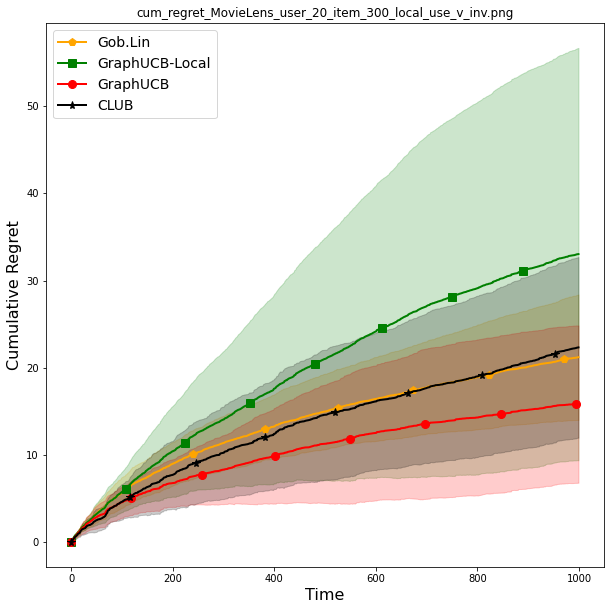

In [72]:
x=range(iteration)
image = plt.figure(figsize=(10,10))
#plt.plot(x, linucb_mean, '-.', markevery=0.1, linewidth=2, markersize=8, label='LinUCB')
#plt.fill_between(x, linucb_mean-linucb_sd, linucb_mean+linucb_sd, color='b', alpha=0.2)
plt.plot(x, gob_mean, '-p', color='orange', markevery=0.1, linewidth=2, markersize=8, label='Gob.Lin')
plt.fill_between(x, gob_mean-gob_sd, gob_mean+gob_sd, color='orange', alpha=0.2)
plt.plot(x, lapucb_sim_mean, '-s', color='g', markevery=0.1, linewidth=2, markersize=8, label='GraphUCB-Local')
plt.fill_between(x, lapucb_sim_mean-lapucb_sim_sd, lapucb_sim_mean+lapucb_sim_sd, color='g', alpha=0.2)
plt.plot(x, lapucb_mean, '-o', color='r', markevery=0.1, linewidth=2, markersize=8, label='GraphUCB')
plt.fill_between(x, lapucb_mean-lapucb_sd, lapucb_mean+lapucb_sd, color='r', alpha=0.2)
plt.plot(x, club_mean, '-*', color='k', markevery=0.1, linewidth=2, markersize=8, label='CLUB')
plt.fill_between(x, club_mean-club_sd, club_mean+club_sd, color='k', alpha=0.2)
plt.ylabel('Cumulative Regret', fontsize=16)
plt.xlabel('Time', fontsize=16)
plt.legend(loc=2, fontsize=14)
#plt.tight_layout()

figure_name = 'cum_regret_' + 'MovieLens' + '_user_' +str(user_num) +'_item_' + str(item_num) +'_local_use_' +'v' + '_inv' + '.png'
plt.title(figure_name)
#plt.savefig(figure_name, dpi=200)
plt.show()
# files.download(figure_name) 

# 9) Netflix Prize dataset  
https://www.kaggle.com/netflix-inc/netflix-prize-data